In [ ]:
import numpy as np
import math
import numpy.linalg as ln
import matplotlib.pyplot as plt
import time
from scipy.interpolate import lagrange, CubicSpline, PchipInterpolator, CubicHermiteSpline, Akima1DInterpolator
from os import times
from sympy import *
init_printing()

# Лаб 3



Вычисление коэффициента сжатия для трёх метрик

In [ ]:
def aInP1():
  aCompres = 0 # коэффициент сжатия по первой метрике
  sum_line = 0
  for i in range(0, matrixSize, 1):
    for j in range(1, matrixSize+1, 1):
      sum_line += abs(matrix_simpleMethod[i, j])
    if aCompres < sum_line:
      aCompres = sum_line
    sum_line = 0
  return aCompres

In [ ]:
def aInP2():
  aCompres = 0 # коэффициент сжатия по первой метрике
  sum_line = 0
  for j in range(1, matrixSize+1, 1):
    for i in range(0, matrixSize, 1):
      sum_line += abs(matrix_simpleMethod[i, j])
    if aCompres < sum_line:
      aCompres = sum_line
    sum_line = 0
  return aCompres

In [ ]:
def aInP3():
  aCompres = 0 # коэффициент сжатия по первой метрике
  for i in range(0, matrixSize, 1):
    for j in range(1, matrixSize+1, 1):
      aCompres += math.pow(matrix_simpleMethod[i, j], 2)
  aCompres = math.sqrt(aCompres)
  return aCompres

Вычисление по метрике

In [ ]:
def metrick(p, oldValues, currentValues):
  if p == 1:
    maxValue = abs(currentValues[0]-oldValues[0]) # берём за максимальный

    # print("Метрика 1   " + str(currentValues[0]) + " " +str(oldValues[0]))

    for i in range(1, matrixSize, 1):
      if (abs(currentValues[i]-oldValues[i]) > maxValue):
        maxValue = abs(currentValues[i]-oldValues[i])

    #   print("Метрика 1   " + str(currentValues[i]) + " " +str(oldValues[i]))
    # print("Максимальное значение" + str(maxValue))

    return maxValue
  elif p == 2:
    pValue = 0
    for i in range(0, matrixSize, 1):
      pValue += abs(currentValues[i]-oldValues[i])

    # print("Метрика 2   " + str(pValue))

    return pValue
  elif p == 3:
    pValue = 0
    for i in range(0, matrixSize, 1):
      pValue += math.pow(currentValues[i]-oldValues[i], 2)
    pValue = math.sqrt(pValue)

    # print("Метрика 3   " + str(pValue))

    return pValue


Итерационный метод

In [ ]:
def theSimpleIterationMethod(p, aCompres): # работает с преобразованной матрицей NxN+1, где первые элементы каждой строки - свободные коэффициенты
  timeStart = time.perf_counter()

  isEnd = False # переменная окончания итераций
  currentValues = np.zeros((matrixSize,)) # текущие значения
  oldValues = None # старые значения
  # print(currentValues)

  while (not isEnd):
    oldValues = np.copy(currentValues)
    tempSumm = None
    for i in range(0, matrixSize, 1):
      tempSumm = matrix_simpleMethod[i, 0]
      for j in range(1, matrixSize+1, 1):
        tempSumm += matrix_simpleMethod[i, j] * oldValues[j-1]
      currentValues[i] = tempSumm # новый вектор
    pValue = metrick(p, oldValues, currentValues)
    if pValue <= eps * ((1 - aCompres) / aCompres):
      isEnd = True

  timeEnd = time.perf_counter()
  print("\nПрошло времени: " + str(timeEnd-timeStart))
  return currentValues

Итерационный метод Зейделя

In [ ]:
def theSimpleIterationZeidelMethod(p, aCompres): # работает с преобразованной матрицей NxN+1, где первые элементы каждой строки - свободные коэффициенты
  timeStart = time.perf_counter()

  isEnd = False # переменная окончания итераций
  values = np.zeros((2, matrixSize)) # старые + текущие значения в виде двумерного массива

  while (not isEnd):
    tempSumm = None
    oldValues = np.copy(values[0,]) #сохранение старых значений для вычисления метрики

    for i in range(0, matrixSize, 1):
      tempSumm = matrix_simpleMethod[i, 0]
      for j in range(1, matrixSize+1, 1):
        tempSumm += matrix_simpleMethod[i, j] * values[(j-1) // matrixSize, (j-1) % matrixSize]
      values[0, i] = tempSumm # перезапись уже неиспользуемых значений
      values[1, i] = tempSumm

    pValue = metrick(p, oldValues, values[1])

    # print(str(pValue), "   ", str(eps * ((1 - aCompres) / aCompres)))

    if pValue <= eps * ((1 - aCompres) / aCompres):
      isEnd = True

  timeEnd = time.perf_counter()
  print("\nПрошло времени: " + str(timeEnd-timeStart))
  return values[1]

Основной код

In [ ]:
x1 = 0
x2 = 0
x3 = 0
matrix_coef = None
matrix_free_coef = None
matrix_simpleMethod = None
matrixSize = None
eps = ''

# считывание данных
def readfile(filename):
  global eps

  f = open(filename)
  text = f.read()
  f.close()

  temp = ''
  coef = ''
  free_coef = ''
  for c in text:
    if(c.isdigit() or c == '-' or c == '.' or c == '^'):
      temp += c
    elif c == '\n':
      if eps != '':
        free_coef += (temp + '; ')
        coef += '; ' # окончание строки
      else:
        eps = temp # погрешность
      temp = ''
    elif c.isalpha():
      if temp == '':
        coef += (str(1) + ' ')
      elif temp == '-':
        coef += (str(-1) + ' ')
      else:
        coef += (temp + ' ')
        temp = ''
  free_coef += temp
  # print(coef)
  # print(free_coef)
  return coef, free_coef, eps

# создание матрицы из полученных данных
def createMatrixs(coef, free_coef, eps): # реализовать проверку корректности системы
  matrix_coef = np.matrix(coef)
  matrix_free_coef = np.array(np.asmatrix(free_coef))
  matrixSize = int(math.sqrt(matrix_coef.size))
  eps = math.pow(10, int(eps[3:]))
  return matrix_coef, matrix_free_coef, matrixSize, eps

# конвертация в читаемую для метода итераци матрицу
def convertMatrixForSimpleMethod():
  matrix_simpleMethod = np.zeros((matrixSize, matrixSize+1)) # преобразуем в систему к виду, допускающему использование метода простой итерации
  for i in range(0, matrixSize, 1):
    matrix_simpleMethod[i, 0] = matrix_free_coef[i, 0] / matrix_coef[i, i] # свободные коэффициенты на первое место
    for j in range(1, matrixSize+1, 1):
      if i == (j-1):
        matrix_simpleMethod[i, j] = 0
      else:
        matrix_simpleMethod[i, j] = matrix_coef[i, j-1] / matrix_coef[i, i] * (-1) # переносим коэффициенты в правую часть и делим на aii
  return matrix_simpleMethod

# вывод значений
def printValues(currentValues):
  for i in range(0, matrixSize, 1):
    print("x" + str(i+1) + " = " + str(currentValues[i]))

# вывод невязок
def printNevyaski(currentValues):
  nevyaski = np.zeros((matrixSize,))
  print("Невязки:")
  for i in range(0, matrixSize, 1):
    tempValue = 0
    for j in range(0, matrixSize, 1):
      tempValue += matrix_coef[i, j] * currentValues[j]
    nevyaski[i] = tempValue - matrix_free_coef[i, 0]
    print("x" + str(i+1) + " = " + str(nevyaski[i]))


In [ ]:
### Создание матриц
coef, free_coef, eps = readfile('drive/MyDrive/urav.txt')
matrix_coef, matrix_free_coef, matrixSize, eps = createMatrixs(coef, free_coef, eps)
matrix_simpleMethod = convertMatrixForSimpleMethod()
### ==========================


p = 0
aCompres = None

### Проверка коэффициента сжатия
# print(aInP1())
# print(aInP2())
# print(aInP3())

aCompres = aInP1()
if (aCompres >= 1): # проверяем первую метрику
  aCompres = aInP2()
  if (aCompres >= 1): # проверяем вторую метрику
    aCompres = aInP3()
    if (aCompres >= 1): # проверяем третью метрику
      print('Итерационная последовательность расходится')
    else:
      p = 3
  else:
    p = 2
else:
  p = 1
### ============================

### Вызов интерационного метода в пространстве с нужной метрикой
if p != 0:
  print("\nИтерационный метод")
  currentValues = theSimpleIterationMethod(p, aCompres)
  printValues(currentValues)
  printNevyaski(currentValues)
  print("\n\n\nИтерационный метод Зейделя")
  currentValues = theSimpleIterationZeidelMethod(p, aCompres)
  printValues(currentValues)
  printNevyaski(currentValues)
### ============================


### Проверка всех трёх метрик
# print("\nПространство с метрикой 1")
# currentValues = theSimpleIterationMethod(1, aInP1())
# printValues(currentValues)
# printNevyaski(currentValues)
# print("\nПространство с метрикой 2")
# currentValues = theSimpleIterationMethod(2, aInP2())
# printValues(currentValues)
# printNevyaski(currentValues)
# print("\nПространство с метрикой 3")
# currentValues = theSimpleIterationMethod(3, aInP3())
# printValues(currentValues)
# printNevyaski(currentValues)

# print("\nПространство с метрикой 1 по Зейделю")
# currentValues = theSimpleIterationZeidelMethod(1, aInP1())
# printValues(currentValues)
# printNevyaski(currentValues)
# print("\nПространство с метрикой 2 по Зейделю")
# currentValues = theSimpleIterationZeidelMethod(2, aInP2())
# printValues(currentValues)
# printNevyaski(currentValues)
# print("\nПространство с метрикой 3 по Зейделю")
# currentValues = theSimpleIterationZeidelMethod(3, aInP3())
# printValues(currentValues)
# printNevyaski(currentValues)
### ============================

# print(matrix_coef) # Коэффициенты
# print(matrix_free_coef) # Свободные коэффициенты


Итерационный метод

Прошло времени: 0.0003613630001382262
x1 = 36.6576354679198
x2 = 26.431034482721238
x3 = 80.51477832506266
Невязки:
x1 = 1.325375365013315e-10
x2 = 1.637943114474183e-10
x3 = 1.3250200936454348e-10



Итерационный метод Зейделя

Прошло времени: 0.00023854299979575444
x1 = 36.657635467977
x2 = 26.431034482757653
x3 = 80.51477832512244
Невязки:
x1 = 9.030998171510873e-12
x2 = 3.808509063674137e-12
x3 = 2.842170943040401e-14


# Лаб 4


Моё значение
$$
lg(x)-\frac{x}{2}+1=0
$$

Получившийся график

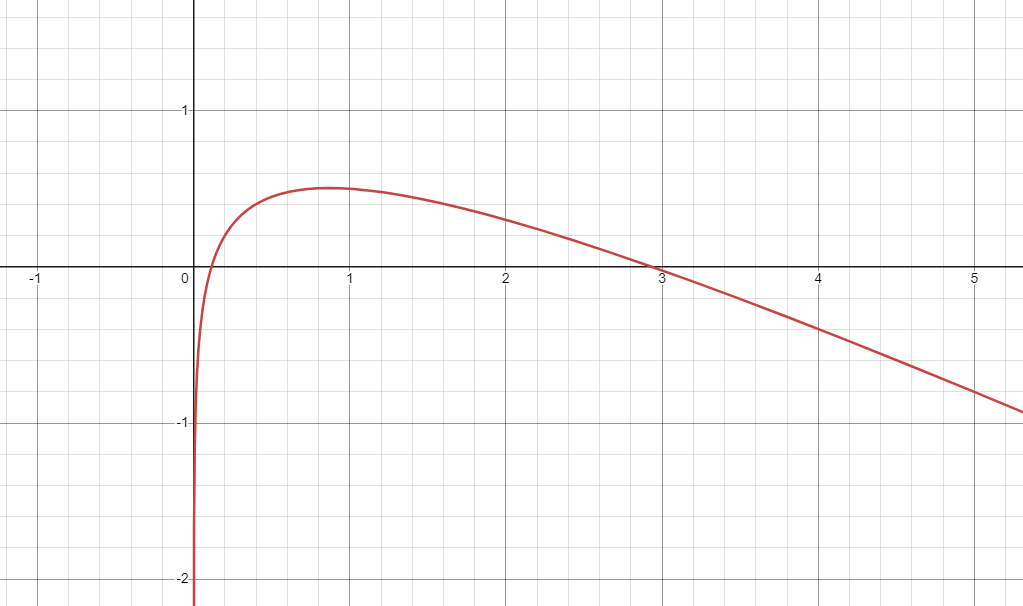

$
lgx-\frac{x}{2}+1=y
$

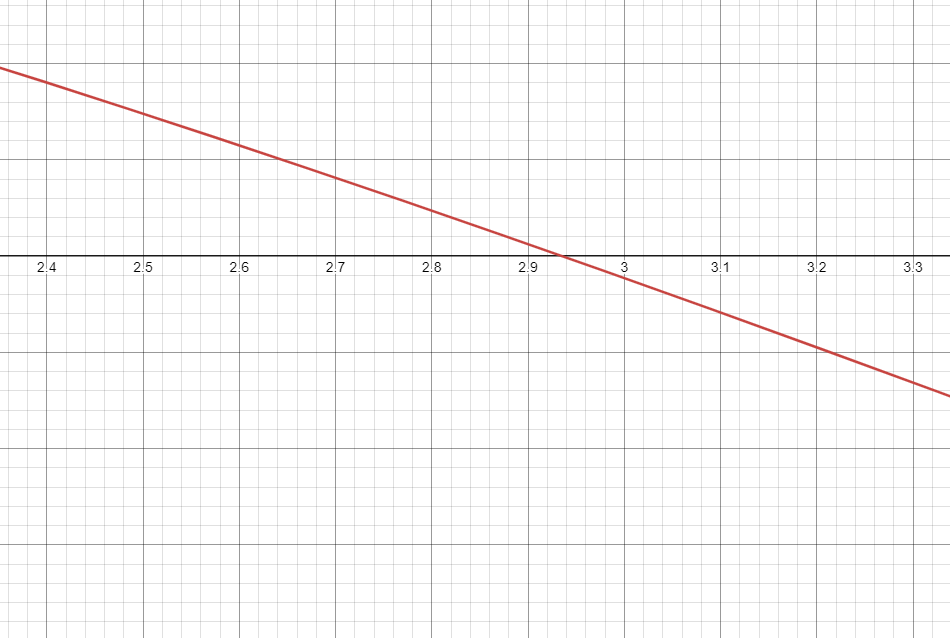

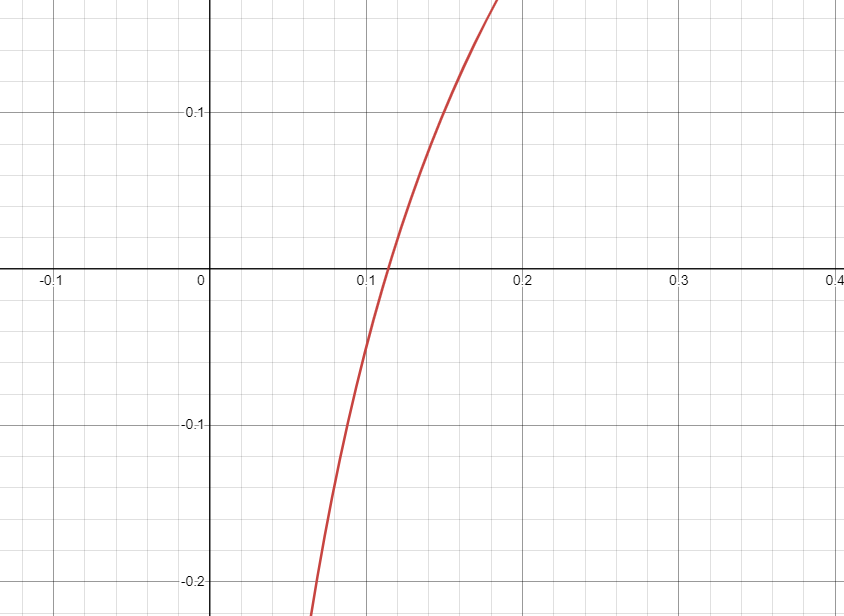

Корни

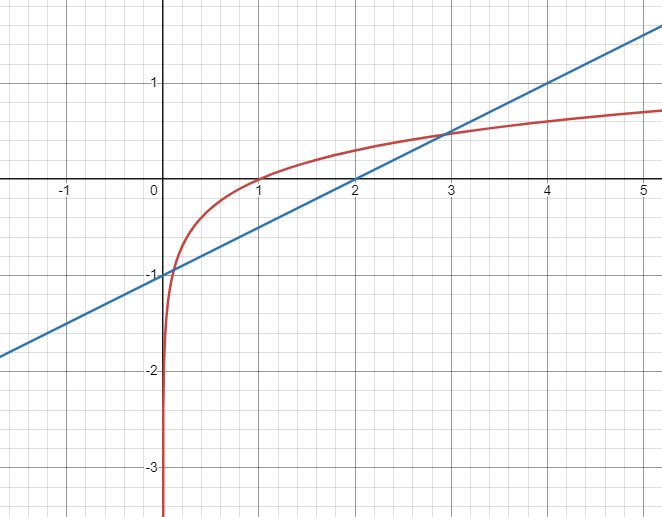

$
lgx=\frac{x}{2}-1
$

Как мы видим, уравнение имеет два корня в отрезках [0, 1] и [2, 3]

Возьмём за отрезки [0.05, 0.6] и [2, 3]

Первая производная:
$
f(x)' = \frac{1}{x*ln10}-\frac{1}{2}
$

Вторая производная:
$
f(x)'' = -\frac{1}{x^2*ln10}
$

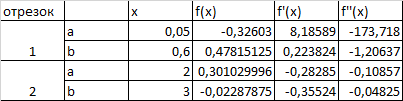

#### Предворительная работа к методу хорд и касательных.

Возьмём отрезки [0.05:0.60] и [2.50:3.50]

In [ ]:
def MyFunc(x):
  base = 10
  return math.log(x, base) - x/2 + 1
i = 0.05
MinValue = MyFunc(i)
MaxValue = MinValue
while i < 0.61:
  MinValue = min(MyFunc(i), MinValue)
  MaxValue = max(MyFunc(i), MaxValue)
  i += 0.01
print(f"[0.05, 0.60]\nМинимум: {MinValue}\nМаксимум: {MaxValue}\n")

i = 2.50
MinValue = MyFunc(i)
MaxValue = MinValue
while i < 3.51:
  MinValue = min(MyFunc(i), MinValue)
  MaxValue = max(MyFunc(i), MaxValue)
  i += 0.01
print(f"[2.50, 3.50]\nМинимум: {MinValue}\nМаксимум: {MaxValue}")

[0.05, 0.60]
Минимум: -0.32602999566398094
Максимум: 0.4781512503836437

[2.50, 3.50]
Минимум: -0.20969288353416804
Максимум: 0.1479400086720376


#### Метод простых итераций

In [ ]:
x = Symbol('x')
f = 2 * log(x, 10) + 2

def FindSolution(epsilon, x0):
  x_n = x0
  iteration = 0
  while True:
    x_next = f.subs({x:x_n}).n(8)
    iteration += 1
    if (abs(x_next - x_n) < epsilon):
      return x_next, iteration
    print(f"Итерация {iteration}: Prev => {x_n}, Next => {x_next}, Diff => {abs(x_next - x_n).n(8)}\n")
    x_n = x_next
x0 = 3
epsilon = 1e-4

x0, iterations = FindSolution(epsilon, x0)
print(f"Приближенный ответ: {x0}, Число итераций: {iterations}")
print(f"Абсолютная погрешность: {abs(f.subs({x:x0}).n(8) - x0)}")

Итерация 1: Prev => 3, Next => 2.9542425, Diff => 0.045757491

Итерация 2: Prev => 2.9542425, Next => 2.9408923, Diff => 0.013350222

Итерация 3: Prev => 2.9408923, Next => 2.9369582, Diff => 0.0039340518

Итерация 4: Prev => 2.9369582, Next => 2.9357955, Diff => 0.0011626929

Итерация 5: Prev => 2.9357955, Next => 2.9354516, Diff => 0.00034392998

Итерация 6: Prev => 2.9354516, Next => 2.9353499, Diff => 0.00010176003

Приближенный ответ: 2.9353197, Число итераций: 7
Абсолютная погрешность: 0.0000089108944


#### Метод половинного деления

In [ ]:
def f(x):
  base = 10
  return math.log(x, base) - x/2 + 1

def dichotomy(a, b, epsilon):
  iteration = 0
  while ((b - a)> epsilon):
    iteration += 1
    c = (b + a) / 2
    #
    print(f"Итерация {iteration}: a = {a}, b = {b}, c = {c}")
    #
    if (f(c) == 0):
      return c
    elif (f(a) * f(c) < 0):
      b = c
    else:
      a = c
  return (a + b) / 2, iteration

a = 2
b = 4
epsilon = 1e-4

x, iterations = dichotomy(a, b, epsilon)

print(f"Вычисленный ответ: {x}\nЧисло итераций: {iterations}\nАбсолютная погрешность: {abs(f(x) - x)}")

Итерация 1: a = 2, b = 4, c = 3.0
Итерация 2: a = 2, b = 3.0, c = 2.5
Итерация 3: a = 2.5, b = 3.0, c = 2.75
Итерация 4: a = 2.75, b = 3.0, c = 2.875
Итерация 5: a = 2.875, b = 3.0, c = 2.9375
Итерация 6: a = 2.875, b = 2.9375, c = 2.90625
Итерация 7: a = 2.90625, b = 2.9375, c = 2.921875
Итерация 8: a = 2.921875, b = 2.9375, c = 2.9296875
Итерация 9: a = 2.9296875, b = 2.9375, c = 2.93359375
Итерация 10: a = 2.93359375, b = 2.9375, c = 2.935546875
Итерация 11: a = 2.93359375, b = 2.935546875, c = 2.9345703125
Итерация 12: a = 2.9345703125, b = 2.935546875, c = 2.93505859375
Итерация 13: a = 2.93505859375, b = 2.935546875, c = 2.935302734375
Итерация 14: a = 2.935302734375, b = 2.935546875, c = 2.9354248046875
Итерация 15: a = 2.935302734375, b = 2.9354248046875, c = 2.93536376953125
Вычисленный ответ: 2.935333251953125
Число итераций: 15
Абсолютная погрешность: 2.9353424635663754


#### Метод Хорд a = 2.5 b = 3.5 x0 = 3.5

In [ ]:
y = Symbol('y')
expre = log(y, 10) - y/2 + 1
dExpre = diff(expre, y)



def f(x):
  base = 10
  return math.log(x, base) - x/2 + 1

def secant(x_prev, E1, a):
  iteration = 0

  print("Номер Итерации\tXi\tf(Xi)\tXi+1\tdelta = |Xi-Xi+1|\tdelta < E1?")
  while True:
    x_next = x_prev - (f(x_prev) * (x_prev - a) / (f(a) - a))

    delta = abs(x_next - x_prev)

    success = "Да" if (delta < E1) else "Нет"

    iteration += 1

    #
    print(f"{iteration}\t{x_prev}\t{f(x_prev)}\t{x_next}\t{delta}\t{success}")
    #

    x_prev = x_next

    if (delta < E1):
      return x_next, iteration



a = 2.5
b = 3.5
m1 = dExpre.subs({y:b}).n(8)
M1 = dExpre.subs({y:a}).n(8)
epsilon = 1e-4
E1 = -1*M1*epsilon/(M1 - m1)
x0 = b

print(f"X0 = 3.5\nE1 = {E1}\n")
result, iterations = secant(x0, E1, a)

print(f"Вычисленный ответ: {result}\nЧисло итераций: {iterations}\nАбсолютная погрешность: {abs(f(result) - 0)}")


X0 = 3.5
E1 = 0.000657380982577482

Номер Итерации	Xi	f(Xi)	Xi+1	delta = |Xi-Xi+1|	delta < E1?
1	3.5	-0.20593195564972433	3.412446129601713	0.08755387039828699	Нет
2	3.412446129601713	-0.1731572606645364	3.3452723870575922	0.06717374254412078	Нет
3	3.3452723870575922	-0.14820470778375228	3.2920112680455653	0.0532611190120269	Нет
4	3.2920112680455653	-0.12854432095714463	3.2487264236892597	0.04328484435630564	Нет
5	3.2487264236892597	-0.11265007103969671	3.2128667580647137	0.03585966562454601	Нет
6	3.2128667580647137	-0.0995406638876648	3.182697786770259	0.03016897129445484	Нет
7	3.182697786770259	-0.08855349126090317	3.1569946700481104	0.025703116722148422	Нет
8	3.1569946700481104	-0.07922348635028853	3.1348653840321608	0.022129286015949656	Нет
9	3.1348653840321608	-0.07121379572565645	3.1156434364889645	0.019221947543196283	Нет
10	3.1156434364889645	-0.06427396835368082	3.098819951161236	0.01682348532772826	Нет
11	3.098819951161236	-0.05821363215473929	3.0839991198506636	0.01482083131

#### Метод касательных

In [ ]:
x = Symbol('x')
f = log(x, 10) - x/2 + 1
df = diff(f, x)
ddf = diff(df, x)

a = 2.5
b = 3.5
epsilon = 1e-4

x0 = a if ddf.subs({x:a}).n(8) * f.subs({x:a}).n(8) > 0 else b
m1 = df.subs({x:b}).n(8)
M2 = ddf.subs({x:b}).n(8)

E1 = sqrt(2*m1*epsilon/M2)

def tangents(x_prev, E1):
  iteration = 0
  print("Номер Итерации\tXi\tf(Xi)\tXi+1\tdelta = |Xi-Xi+1|\tdelta < E1?")
  while True:
    x_next = x_prev - (f.subs({x:x_prev}).n(8)/df.subs({x:x_prev}).n(8))

    delta = abs(x_next - x_prev)

    iteration += 1

    success = "Да" if delta < E1 else "Нет"

    #
    print(f"{iteration}\t{x_prev}\t{f.subs({x:x_prev}).n(8)}\t{x_next}\t{delta}\t{success}")
    #

    if (delta < E1):
      return x_next, iteration
    x_prev = x_next

print(f"X0 = {x0}\nE1 = {E1}\n")
result, iterations = tangents(x0, E1)

print(f"Вычисленный ответ: {result}\nЧисло итераций: {iterations}\nАбсолютная погрешность: {abs(f.subs({x:result}).n(8) - 0)}")

X0 = 3.5
E1 = 0.0460506974842068

Номер Итерации	Xi	f(Xi)	Xi+1	delta = |Xi-Xi+1|	delta < E1?
1	3.5	-0.20593196	2.95218604337424	0.547813956625760	Нет
2	2.95218604337424	-0.0059492989	2.93532727786805	0.0168587655061856	Да
Вычисленный ответ: 2.93532727786805
Число итераций: 2
Абсолютная погрешность: 0.0000071084618


# Лаб 5


## Часть 1

**Дана следующая система:**
$$
\begin{cases}
  \sin(y-1)+x=0,15
  \\y+\sin(x+1)=0,78
\end{cases}
$$
\
**Построим график:**

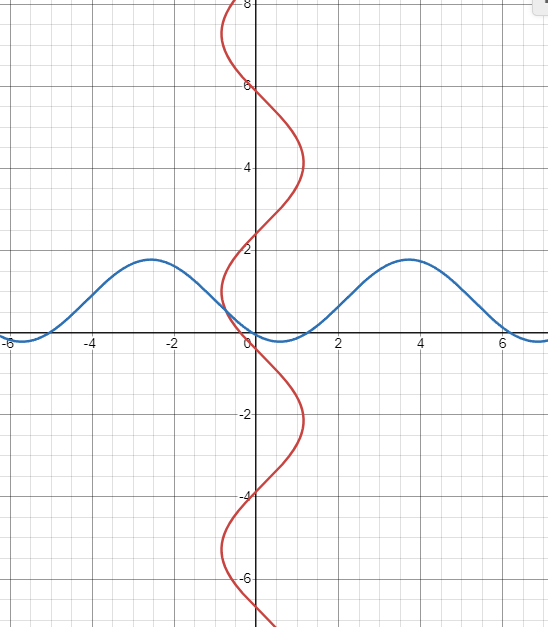

Мы имеем одну точку пересечения во втором квадранте.

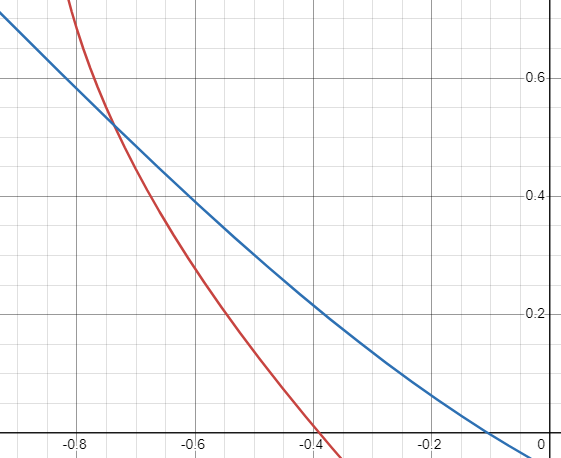

Преобразовав систему к итерационному виду, получаем:
$$
\begin{cases}
  x = 0,15-\sin(y-1)
  \\y = 0,78-\sin(x+1)
\end{cases}
$$

За начальное приближение возьмём точку **$$x^{(0)}=(-0.8,0.6)^T$$**
\
Далее мы будем рассматривать окрестность взятой точки $x^{(0)}$:
$$G=\{|x+0,8|\leq0,1; |y-0,6|\leq0,1\}$$

Для проверки на сходимость итерационных методов, напишем код:

In [ ]:
x, y = symbols('x y')
xf = 0.15 - cos(y-1)
yf = 0.78 - sin(x+1)
dxfx = diff(xf, x) # = 0
dxfy = diff(xf, y)
dyfx = diff(yf, x)
dyfy = diff(yf, y) # = 0

ax = -0.9
bx = -0.7
ay = 0.7
by = 0.5

M1 = max(abs(dxfy.subs({y:ay}).n(8)), abs(dxfy.subs({y:by}).n(8))) + max(abs(dxfx.subs({x:ax}).n(8)), abs(dxfx.subs({x:bx}).n(8))) # сумма частных производных первого уравнения
M2 = max(abs(dyfx.subs({x:ax}).n(8)), abs(dyfx.subs({x:bx}).n(8))) + max(abs(dyfy.subs({y:ay}).n(8)), abs(dyfy.subs({y:by}).n(8))) # сумма частных производных второго уравнения

M = max(M1, M2) # максимальное из сумм

if (M < 1):
  print("Достаточное условие сходимости выполняется")
else:
  print("Достаточное условие сходимости не выполняется")

Достаточное условие сходимости выполняется


## Часть 2


Таблица значений:

|Метод|Полученное решение системы($x_1, x_2$)|Количество итераций|Значения невязок|Время работы($секунды$)|
|-|-|-|-|-|
|Простых итераций|$(-0.73700960, 0.52003137)$|26|X:-1.86823308462314E-7, Y:6.66156411144314E-7|0.03243661|
|Зейделя|$(-0.73700910, 0.52003023)$|14|X:-2.19419598573856E-7, Y:2.60770294246981E-10|0.00973201|
|Ньютона|$(-0.73700870, 0.52002984)$|4|X:1.38777878078145E-16, Y:0|0.07976770|
|Упрощённый метод Ньютона|$(-0.73697610, 0.51999543)$|15|X:-1.67173788593322e-5, Y:2.92436564119924e-6|0.10163450|




**Метод простых итераций:**

In [ ]:
def simple_iterations(epsilon):
    x_cur, y_cur = -0.8, 0.6  # нач приближение (x1, x2)
    x_old, y_old = x_cur, y_cur
    iterations = 0
    start_time = time.time()  # фикс время начала

    x_cur = xf.subs({x:x_old, y:y_old}).n(8)
    y_cur = yf.subs({x:x_old, y:y_old}).n(8)

    while (max(abs(x_cur - x_old), abs(y_cur - y_old)) >= epsilon):
        # обновление значений
        x_old, y_old = x_cur, y_cur
        iterations += 1

        # вычисл новых знач x1 и x2
        x_cur = xf.subs({x:x_old, y:y_old}).n(8)
        y_cur = yf.subs({x:x_old, y:y_old}).n(8)
        print(f"Итерация {iterations}: x = {x_cur:.8f}, y = {y_cur:.8f}")

    end_time = time.time()  # фикс время конца
    elapsed_time = end_time - start_time  # вычисл времени

    return x_cur, y_cur, iterations, elapsed_time



epsilon = 10**-6
x, y = symbols('x y')
xf = 0.15 - cos(y-1)
yf = 0.78 - sin(x+1)

x_res, y_res, count, elapsed_time = simple_iterations(epsilon)

print(f"\nРезультаты x = {x_res} y = {y_res}")
print(f"Время выполнения: {elapsed_time:.8f}")
print(f"Количество итераций: {count}")
nevyaskiX = (cos(y_res-1)+x_res-0.15)
nevyaskiY = (y_res+sin(x_res+1)-0.78)
print(f"Невязки: \nX:{nevyaskiX} \nY:{nevyaskiY}")

Итерация 1: x = -0.76363073, y = 0.55305566
Итерация 2: x = -0.75177200, y = 0.54582559
Итерация 3: x = -0.74862354, y = 0.53431334
Итерация 4: x = -0.74351344, y = 0.53126261
Итерация 5: x = -0.74213939, y = 0.52631638
Итерация 6: x = -0.73989398, y = 0.52498752
Итерация 7: x = -0.73928702, y = 0.52281700
Итерация 8: x = -0.73829223, y = 0.52223049
Итерация 9: x = -0.73802271, y = 0.52126945
Итерация 10: x = -0.73758041, y = 0.52100912
Итерация 11: x = -0.73746046, y = 0.52058194
Итерация 12: x = -0.73726350, y = 0.52046609
Итерация 13: x = -0.73721006, y = 0.52027589
Итерация 14: x = -0.73712229, y = 0.52022428
Итерация 15: x = -0.73709847, y = 0.52013952
Итерация 16: x = -0.73705934, y = 0.52011652
Итерация 17: x = -0.73704872, y = 0.52007874
Итерация 18: x = -0.73703128, y = 0.52006849
Итерация 19: x = -0.73702655, y = 0.52005165
Итерация 20: x = -0.73701877, y = 0.52004707
Итерация 21: x = -0.73701666, y = 0.52003956
Итерация 22: x = -0.73701319, y = 0.52003753
Итерация 23: x = -0

**Метод Зейделя**

In [ ]:
def zeidel_iterations(epsilon):
    x_cur, y_cur = -0.8, 0.6  # нач приближение (x1, x2)
    x_old, y_old = x_cur, y_cur
    iterations = 0
    start_time = time.time()  # фикс время начала

    x_cur = xf.subs({x:x_old, y:y_old}).n(8)
    y_cur = yf.subs({x:x_cur, y:y_old}).n(8)

    while (max(abs(x_cur - x_old), abs(y_cur - y_old)) >= epsilon):
        # обновление значений
        x_old, y_old = x_cur, y_cur
        iterations += 1

        # вычисл новых знач x1 и x2
        x_cur = xf.subs({x:x_old, y:y_old}).n(8)
        y_cur = yf.subs({x:x_cur, y:y_old}).n(8)
        print(f"Итерация {iterations}: x = {x_cur:.8f}, y = {y_cur:.8f}")

    end_time = time.time()  # фикс время конца
    elapsed_time = end_time - start_time  # вычисл времени

    return x_cur, y_cur, iterations, elapsed_time



epsilon = 10**-6
x, y = symbols('x y')
xf = 0.15 - cos(y-1)
yf = 0.78 - sin(x+1)

x_res, y_res, count, elapsed_time = zeidel_iterations(epsilon)

print(f"\nРезультаты x = {x_res} y = {y_res}")
print(f"Время выполнения: {elapsed_time:.8f}")
print(f"Количество итераций: {count}")
nevyaskiX = (cos(y_res-1)+x_res-0.15)
nevyaskiY = (y_res+sin(x_res+1)-0.78)
print(f"Невязки: \nX:{nevyaskiX} \nY:{nevyaskiY}")

Итерация 1: x = -0.75177200, y = 0.53431334
Итерация 2: x = -0.74351344, y = 0.52631638
Итерация 3: x = -0.73989398, y = 0.52281700
Итерация 4: x = -0.73829223, y = 0.52126945
Итерация 5: x = -0.73758041, y = 0.52058194
Итерация 6: x = -0.73726350, y = 0.52027589
Итерация 7: x = -0.73712229, y = 0.52013952
Итерация 8: x = -0.73705934, y = 0.52007874
Итерация 9: x = -0.73703128, y = 0.52005165
Итерация 10: x = -0.73701877, y = 0.52003956
Итерация 11: x = -0.73701319, y = 0.52003418
Итерация 12: x = -0.73701070, y = 0.52003178
Итерация 13: x = -0.73700960, y = 0.52003070
Итерация 14: x = -0.73700910, y = 0.52003023

Результаты x = -0.73700910 y = 0.52003023
Время выполнения: 0.00973201
Количество итераций: 14
Невязки: 
X:-2.19419598573856E-7 
Y:2.60770294246981E-10


**Метод Ньютона:**

In [ ]:
def Newton(epsilon):
    x_cur, y_cur = -0.8, 0.6  # нач приближение (x1, x2)
    iterations = 0
    start_time = time.time()  # фикс время начала

    J = Matrix([[diff(f1, x), diff(f1, y)],[diff(f2, x), diff(f2, y)]])
    F = Matrix([f1, f2])
    delta = Matrix([epsilon+1, epsilon+1])

    while (max(delta) > epsilon):
      iterations += 1

      J_val = J.subs({x:x_cur, y:y_cur}).evalf()
      F_val = F.subs({x:x_cur, y:y_cur}).evalf()

      # Решение системы уравнений с использованием LU-разложения
      delta = -J_val.LUsolve(F_val)

      x_cur += delta[0]
      y_cur += delta[1]

      print(f"Итерация {iterations}: x = {x_cur}, y = {y_cur}, dx = {delta[0]}, dy = {delta[1]}")

    end_time = time.time()  # фикс время конца
    elapsed_time = end_time - start_time  # вычисл времени

    return x_cur, y_cur, iterations, elapsed_time

epsilon = 10**-6
x, y = symbols('x y')
f1 = 0.15 - cos(y-1) - x
f2 = 0.78 - sin(x+1) - y

x_res, y_res, count, elapsed_time = Newton(epsilon)

print(f"\nРезультаты x = {x_res:.8f} y = {y_res:.8f}")
print(f"Время выполнения: {elapsed_time:.8f}")
print(f"Количество итераций: {count}")
nevyaskiX = (cos(y_res-1)+x_res-0.15)
nevyaskiY = (y_res+sin(x_res+1)-0.78)
print(f"Невязки: \nX:{nevyaskiX} \nY:{nevyaskiY}")

Итерация 1: x = -0.741441689230928, y = 0.523939625965331, dx = 0.0585583107690717, dy = -0.0760603740346691
Итерация 2: x = -0.737018813940388, y = 0.520037091652084, dx = 0.00442287529054059, dy = -0.00390253431324707
Итерация 3: x = -0.737008703613675, y = 0.520029843714970, dx = 0.0000101103267127924, dy = -0.00000724793711338455
Итерация 4: x = -0.737008703582701, y = 0.520029843698348, dx = 3.09739478778314E-11, dy = -1.66224768117391E-11

Результаты x = -0.73700870 y = 0.52002984
Время выполнения: 0.07976770
Количество итераций: 4
Невязки: 
X:1.38777878078145E-16 
Y:0


**Упрощённый метод Ньютона:**

In [ ]:
def Newton(epsilon):
    x_cur, y_cur = 0.0, 0.0  # нач приближение (x1, x2)
    iterations = 0
    start_time = time.time()  # фикс время начала

    J = Matrix([[diff(f1, x), diff(f1, y)],[diff(f2, x), diff(f2, y)]])
    J_val = J.subs({x:x_cur, y:y_cur}).evalf()
    J_val = np.array(J_val).astype(np.float64)
    J_invert = np.linalg.inv(J_val)
    F = Matrix([f1, f2])
    delta = Matrix([epsilon+1, epsilon+1])

    while (max(delta) > epsilon):
      iterations += 1

      F_val = F.subs({x:x_cur, y:y_cur}).evalf()

      # Решение системы уравнений с использованием LU-разложения
      delta = -J_invert*F_val

      x_cur += delta[0]
      y_cur += delta[1]

      print(f"Итерация {iterations}: x = {x_cur}, y = {y_cur}, dx = {delta[0]}, dy = {delta[1]}")

    end_time = time.time()  # фикс время конца
    elapsed_time = end_time - start_time  # вычисл времени

    return x_cur, y_cur, iterations, elapsed_time

epsilon = 10**-6
x, y = symbols('x y')
f1 = 0.15 - cos(y-1) - x
f2 = 0.78 - sin(x+1) - y

x_res, y_res, count, elapsed_time = Newton(epsilon)

print(f"\nРезультаты x = {x_res:.8f} y = {y_res:.8f}")
print(f"Время выполнения: {elapsed_time:.8f}")
print(f"Количество итераций: {count}")
nevyaskiX = (0.15 - cos(y_res-1) - x_res)
nevyaskiY = (0.78 - sin(x_res+1) - y_res)
print(f"Невязки: \nX:{nevyaskiX:e} \nY:{nevyaskiY:e}")

Итерация 1: x = -0.620840665589254, y = 0.273970658386688, dx = -0.620840665589254, dy = 0.273970658386688
Итерация 2: x = -0.788297878276956, y = 0.500337876115761, dx = -0.167457212687702, dy = 0.226367217729073
Итерация 3: x = -0.784558380894517, y = 0.567855216210319, dx = 0.00373949738243880, dy = 0.0675173400945577
Итерация 4: x = -0.733464991301535, y = 0.538615264864547, dx = 0.0510933895929829, dy = -0.0292399513457716
Итерация 5: x = -0.721463151903765, y = 0.510124994109313, dx = 0.0120018393977696, dy = -0.0284902707552346
Итерация 6: x = -0.733673175971300, y = 0.511647920999643, dx = -0.0122100240675353, dy = 0.00152292689032991
Итерация 7: x = -0.740601115915144, y = 0.520553636773301, dx = -0.00692793994384327, dy = 0.00890571577365816
Итерация 8: x = -0.739003889316631, y = 0.522637421701568, dx = 0.00159722659851285, dy = 0.00208378492826707
Итерация 9: x = -0.736497709521676, y = 0.520602849705725, dx = 0.00250617979495496, dy = -0.00203457199584287
Итерация 10: x = 

# Лаб 6

## Часть 1

Вычисление приближённого значения для $\sqrt{117}$ методом интерполяции.

Дана следующая таблица значений узлов интерполяции:

|x|100|121|144|
|-|-|-|-|
|$\sqrt{x}$|10|11|12|

\
#### **Построение интерполяционного многочлена Лагранжа.**

Вычисления будем проводить по следующей формуле
$$L_n(x) = \sum_{i=0}^ny_i\frac{(x-x_0)(x-x_1)...(x-x_{i-1})(x-x_{i+1})...(x-x_n))}{(x_i-x_0)(x_i-x_1)...(x_i-x_{i-1})(x_i-x_{i+1})...(x_i-x_n))}$$

**Решение:**

Представим корень как f(x)

$$
L_2(x) = 10\frac{(x-121)(x-144)}{(100-121)(100-144)}+11\frac{(x-100)(x-144)}{(121-100)(121-144)}+12\frac{(x-100)(x-121)}{(144-100)(144-121)} = 10\frac{x^2-121x-144x+17424}{924}+11\frac{x^2-100x-144x+14400}{-483}+12\frac{x^2-100x-121x+12100}{1012}=\frac{10}{924}(x^2-265x+17424)-\frac{11}{483}(x^2-244x+14400)+\frac{12}{1012}(x^2-221x+12100)=-\frac{1}{10626}x^2+\frac{727}{10626}x+\frac{43560}{10626}=-\frac{1}{10626}(x^2-727x-43560)
$$

Итоговый многочлен:

$$
L_2(x)=-\frac{1}{10626}x^2+\frac{727}{10626}x+\frac{43560}{10626}
$$

Проверим по графику:

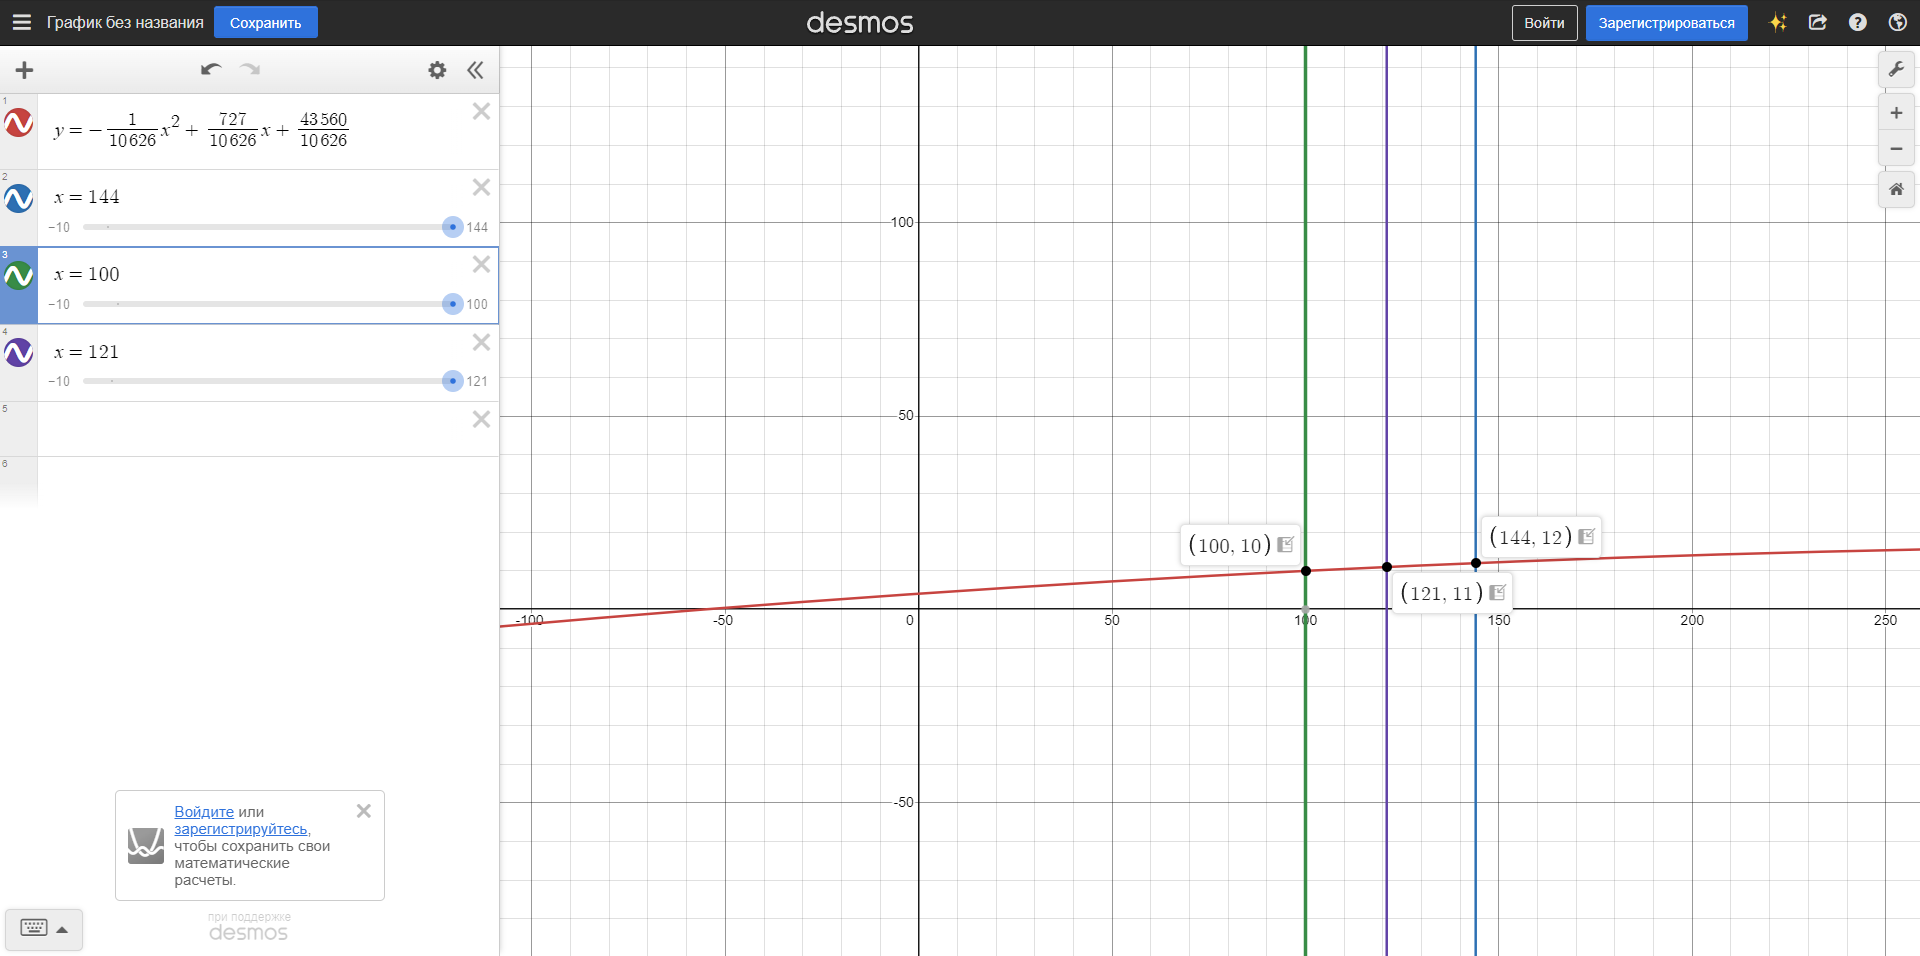

Как мы видим, точки сходятся.

#### **Вычисление приближённого значения $\sqrt{117}$:**
$$
L_2(117) = -\frac{117^2}{10626}+\frac{727*117}{10626}+\frac{43560}{10626}=10\frac{1445}{1771}\approx10.81592320...
$$

#### **Вычисление погрешности:**

Точное значение:
$\sqrt{117}=10.8166538...$

**Абсолютная погрешность:**

Абсолютная погрешность = ∣Интерполированное значение - Точное значение∣ = |10.81592320 - 10.8166538| = 0.00073058

**Относительная погрешность:**

Относительная погрешность = $\frac{Абсолютная\ погрешность}{Точное\ значение}$x100% = $\frac{0.00073058}{10.8166538}$x100% = 0.00675%

**Количество верных цифр - 4**

С увеличением узлов, увеличивается и точность графика.
Проверим это. Добавим ещё одну точку (81, 9) и перепишем выражение:

$$
L_2(x) = 10\frac{(x-81)(x-121)(x-144)}{(100-81)(100-121)(100-144)}+11\frac{(x-81)(x-100)(x-144)}{(121-81)(121-100)(121-144)}+12\frac{(x-81)(x-100)(x-121)}{(144-81)(144-100)(144-121)}+9\frac{(x-100)(x-121)(x-144)}{(81-100)(81-121)(81-144)} = 10\frac{(x-81)(x-121)(x-144)}{17556}+11\frac{(x-81)(x-100)(x-144)}{−19320}+12\frac{(x-81)(x-100)(x-121)}{63756}+9\frac{(x-100)(x-121)(x-144)}{−47880}=\frac{1}{2018940}x^3-\frac{37}{134596}x^2+\frac{91027}{1009470}+\frac{9900}{3059}
$$

Итоговый многочлен:

$$
F_3(x)=\frac{1}{2018940}x^3-\frac{37}{134596}x^2+\frac{91027}{1009470}+\frac{9900}{3059}
$$

Проверим по графику:

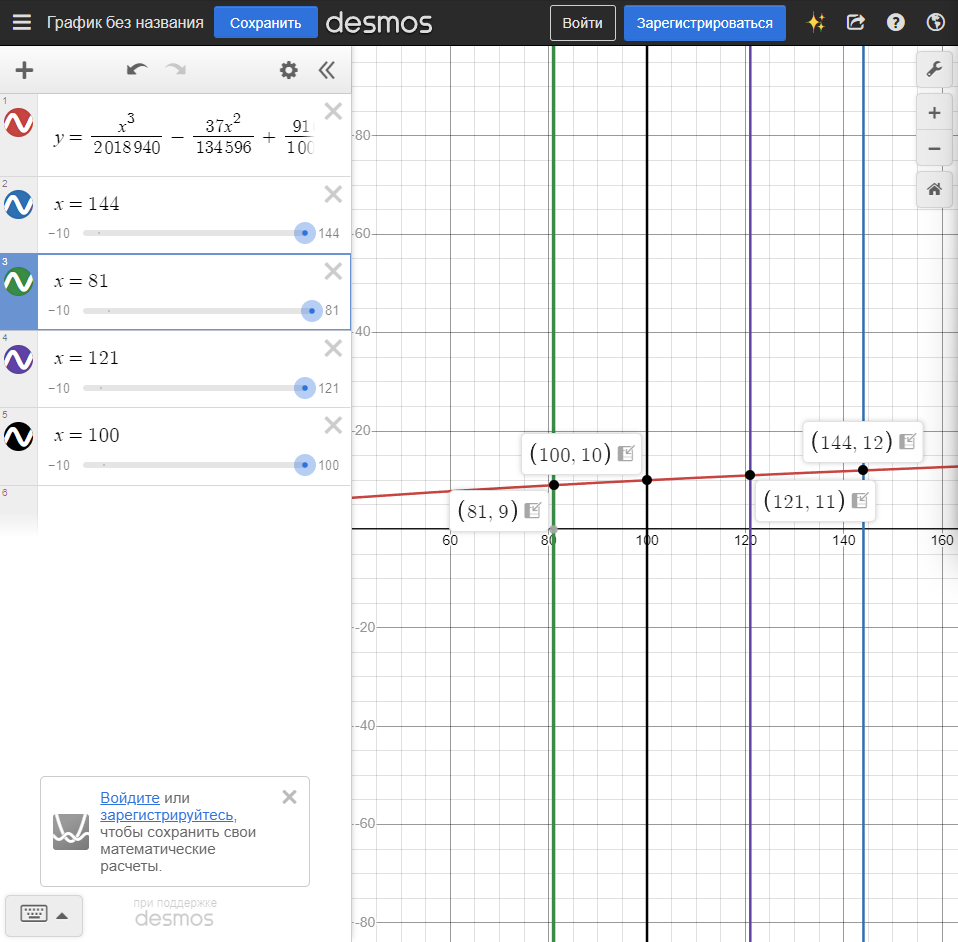

### **Повторное вычисление приближённого значения $\sqrt{117}$:**
$$
L_3(117) = \frac{117^3}{2018940}-\frac{37*117^2}{134596}+\frac{91027*117}{1009470}+\frac{9900}{3059}=10\frac{137428}{168245}\approx10.81683259...
$$

#### **Вычисление погрешности:**

**Абсолютная погрешность:**

Абсолютная погрешность = ∣Интерполированное значение - Точное значение∣ = |10.81683259 - 10.8166538| = 0.00017879

**Относительная погрешность:**

Относительная погрешность = $\frac{Абсолютная\ погрешность}{Точное\ значение}$x100% = $\frac{0.00017879}{10.8166538}$x100% = 0.00165%

**Теперь, количество верных цифр - 5, значение стало более точным**

## Часть 2

Фнукция для вычисления значения функции с помощью интерполяционного многочлена Лагранджа

In [ ]:
def lagrangeInterpolation(xValues, yValues, xTarget):
  n = len(xValues)
  result = 0

  for i in range(n):
    term = yValues[i]
    for j in range(n):
      if i != j:
        term *= (xTarget-xValues[j])/(xValues[i]-xValues[j])
    result += term

  return result

Проверка  + вычисление погрешности для **x*=3.5** по таблице

|X|1.2|1.9|3.3|4.7|5.4|6.8|7.5|
|-|-|-|-|-|-|-|-|
|Y=ln2,3x-0,8/x|0.3486|1.0537|1.7844|2.2103|2.3712|2.6322|2.7411|

In [ ]:
xValues = [1.2, 1.9, 3.3, 4.7, 5.4, 6.8, 7.5]
yValues = [0.3486, 1.0537, 1.7844, 2.2103, 2.3712, 2.6322, 2.7411]

xTarget = 3.5

approxy = lagrangeInterpolation(xValues, yValues, xTarget) #приближённое
correctY = np.log(2.3 * xTarget) - 0.8 / xTarget #точное
err = abs(approxy - correctY) #абслютная погрешность
err2 = err/correctY*100

print("Проверка правильности")
for i in range(len(xValues)):
  print(f"x={xValues[i]} y={lagrangeInterpolation(xValues, yValues, xValues[i])}")

print(f"\nПриближённое значение через интерполяционный многочлен Лагранджа в точке x*={xTarget}: {approxy}")
print(f"Точное значение функции в точке x*={xTarget}: {correctY}")

print(f"Абсолютная погрешность: {err:.8f}")
print(f"Относительная погрешность: {err2:.4f}%")

Проверка правильности
x=1.2 y=0.3486
x=1.9 y=1.0537
x=3.3 y=1.7844
x=4.7 y=2.2103
x=5.4 y=2.3712
x=6.8 y=2.6322
x=7.5 y=2.7411

Приближённое значение через интерполяционный многочлен Лагранджа в точке x*=3.5: 1.8562855836712027
Точное значение функции в точке x*=3.5: 1.8571006628590432
Абсолютная погрешность: 0.00081508
Относительная погрешность: 0.0439%


## Часть 3

Построение таблицы по функции $y = ln 2.3x-\frac{0.8}{x}$ с равным шагом h

In [ ]:
step = 1.5
value = 1.5
for i in range(7):
  print(f"x={value} y={(np.log(2.3 * value) - 0.8 / value):.3f}")
  value += step

x=1.5 y=0.705
x=3.0 y=1.665
x=4.5 y=2.159
x=6.0 y=2.491
x=7.5 y=2.741
x=9.0 y=2.941
x=10.5 y=3.108


Имеем следующую таблицу:

|X|1.5|3|4.5|6|7.5|9|10.5|
|-|-|-|-|-|-|-|-|
|y=ln2.3x-0.8/x|0.705|1.665|2.159|2.491|2.741|2.941|3.108|

\
**Таблица конечных разностей:**

|$x_0$|$y_0$|$\Delta y_0$|$\Delta^2 y_0$|$\Delta^3 y_0$|$\Delta^4 y_0$|$\Delta^5 y_0$|$\Delta^6 y_0$|
|-|-|-|-|-|-|-|-|
|1.5|0.705|0.960|-0.466|0.304|-0.224|0.176|-0.143|
|3|1.665|0.494|-0.162|0.080|-0.048|0.033|x|
|4.5|2.159|0.332|-0.082|0.032|-0.015|x|x|
|6|2.491|0.250|-0.050|0.017|x|x|x|
|7.5|2.741|0.200|-0.033|x|x|x|x|
|9|2.941|0.167|x|x|x|x|x|
|10.5|3.108|x|x|x|x|x|x|

В этой таблице нет конечных разностей, практически равных нулю.

**Степень интерполяционного многочлена = 6**

Вычисление таблицы конечных разностей

In [ ]:
def finiteDifferences(yValues, tolerance=1e-5):
  differences = [yValues]

  while True:
    currentDiff = np.diff(differences[-1])  # Вычисление разностей
    differences.append(currentDiff)

    # Проверяем, равны ли все элементы текущего уровня 0 с заданной точностью
    if all(abs(val) < tolerance for val in currentDiff):
      break

  return differences

Первый интерполяционный метод Ньютона

In [ ]:
def firstNewton(xValues, yDiff, xTarget):
  n = len(xValues)
  result = yDiff[0][0]
  h = xValues[1] - xValues[0]

  for i in range(1, n, 1):
    term = round(yDiff[i][0], 3)/(math.factorial(i)*pow(h, i))
    for j in range(i):
      term *= (xTarget - xValues[j])
    result += term

  return result


In [ ]:
def secondNewton(xValues, yDiff, xTarget):
  n = len(xValues)
  result = yDiff[0][n-1]
  h = xValues[1] - xValues[0]

  for i in range(1, n, 1):
    term = round(yDiff[i][n-1-i], 3)/(math.factorial(i)*pow(h, i)) # двигаемся по лесенке
    for j in range(i):
      term *= (xTarget - xValues[n-1-j]) # берём иксы с конца
    result += term

  return result


In [ ]:
xValues = [1.5, 3, 4.5, 6, 7.5, 9, 10.5]
yValues = [0.705, 1.665, 2.159, 2.491, 2.741, 2.941, 3.108]
yDiff = finiteDifferences(yValues) # вычисление конечных разностей
xTarget = 3.5

Newton1 = firstNewton(xValues, yDiff, xTarget) # первый
Newton2 = secondNewton(xValues, yDiff, xTarget) # второй
correctY = np.log(2.3 * xTarget) - 0.8 / xTarget #точное
errNew1 = abs(Newton1 - correctY) #абслютная погрешность
err2New1 = errNew1/correctY*100
errNew2 = abs(Newton2 - correctY) #абслютная погрешность
err2New2 = errNew2/correctY*100



print(f"Точное значение функции в точке x*={xTarget}: {correctY}")
print(f"Первый интерполяционный многочлен Ньютона: {Newton1}")
print(f"Абсолютная погрешность: {errNew1}")
print(f"Относительная погрешность: {err2New1}%")

print(f"Второй интерполяционный многочлен Ньютона: {Newton2}")
print(f"Абсолютная погрешность: {errNew2}")
print(f"Относительная погрешность: {err2New2}%")

Точное значение функции в точке x*=3.5: 1.8571006628590432
Первый интерполяционный многочлен Ньютона: 1.8589326322206978
Абсолютная погрешность: 0.0018319693616546395
Относительная погрешность: 0.09864674534304924%
Второй интерполяционный многочлен Ньютона: 1.858932632220698
Абсолютная погрешность: 0.0018319693616548616
Относительная погрешность: 0.09864674534306118%


## Часть 4

### Интерполяционный метод Лагранджа

In [ ]:
xValues = [1.5, 3, 4.5, 6, 7.5, 9, 10.5]
yValues = [0.705, 1.665, 2.159, 2.491, 2.741, 2.941, 3.108]
xTarget = 3.5

lag_polynomial = lagrange(xValues, yValues)

y_interp = lag_polynomial(xTarget)
print(f"Интерполяционный метод Лагранджа для точки x*=3.5: {y_interp}")


# погрешность
correctY = np.log(2.3 * xTarget) - 0.8 / xTarget #точное
err = abs(y_interp - correctY) #абслютная погрешность
err2 = err/correctY*100 # относительная погрешность
print(f"Абсолютная погрешность: {err:.8f}")
print(f"Относительная погрешность: {err2:.4f}%")

Интерполяционный метод Лагранджа для точки x*=3.5: 1.858932632220664
Абсолютная погрешность: 0.00183197
Относительная погрешность: 0.0986%


### Методы интерполяции CubicSpline, PchipInterpolator, CubicHermiteSpline, Akima1DInterpolator

In [ ]:
xValues = [1.5, 3, 4.5, 6, 7.5, 9, 10.5]
yValues = [0.705, 1.665, 2.159, 2.491, 2.741, 2.941, 3.108]
xTarget = 3.5
correctY = np.log(2.3 * xTarget) - 0.8 / xTarget #точное

# создание массива производных
x, y = symbols('x y')
func = log(2.3 * x, 10) - 0.8 / x
derFunc = diff(func, x)
derValues = [] #значения производных
for i in range(len(xValues)):
  derValues.append(derFunc.subs({x:xValues[i]}))


# Интерполяция Cubic Spline
cubic_spline = CubicSpline(xValues, yValues)
yCubicSpline = cubic_spline(xTarget)
err1 = abs(yCubicSpline - correctY)

# Интерполяция Pchip
pchip = PchipInterpolator(xValues, yValues)
yPchip = pchip(xTarget)
err2 = abs(yPchip - correctY)

# Интерполяция Cubic Hermite Spline
cubic_hermite_spline = CubicHermiteSpline(xValues, yValues, derValues)
yCubicHermitSpline = cubic_hermite_spline(xTarget)
err3 = abs(yCubicHermitSpline - correctY)

# Интерполяция Akima
akima = Akima1DInterpolator(xValues, yValues)
yAkima = akima(xTarget)
err4 = abs(yAkima - correctY)

# Оценка погрешности
print(f"\nCubic Spline интерполяция: {yCubicSpline}")
print(f"Абсолютная погрешность: {err1:.6f}")
print(f"Относительная погрешность: {((err1/correctY)*100):.6f}%")
print(f"\nPchip интерполяция: {yPchip}")
print(f"Абсолютная погрешность: {err2:.6f}")
print(f"Относительная погрешность: {((err2/correctY)*100):.6f}%")
print(f"\nCubic Hermite Spline интерполяция: {yCubicHermitSpline}")
print(f"Абсолютная погрешность: {err3:.6f}")
print(f"Относительная погрешность: {((err3/correctY)*100):.6f}%")
print(f"\nAkima интерполяция: {yAkima}")
print(f"Абсолютная погрешность: {err4:.6f}")
print(f"Относительная погрешность: {((err4/correctY)*100):.6f}%")



Cubic Spline интерполяция: 1.8636252204585537
Абсолютная погрешность: 0.006525
Относительная погрешность: 0.351330%

Pchip интерполяция: 1.8602989216306307
Абсолютная погрешность: 0.003198
Относительная погрешность: 0.172218%

Cubic Hermite Spline интерполяция: 1.8298842268155242
Абсолютная погрешность: 0.027216
Относительная погрешность: 1.465534%

Akima интерполяция: 1.8576799634261625
Абсолютная погрешность: 0.000579
Относительная погрешность: 0.031194%


Самый точный метод сплайн-интерполяции из модуля scipy.interpolate является Akima1DInterpolator.
Так же, как мы видим, он самый точный среди всех методов интерполяции, включая ИМЛ и ИМН для данной функции и данных значений.

# Лаб 7

## Часть 1

### **Линейная функция**

Расчёты

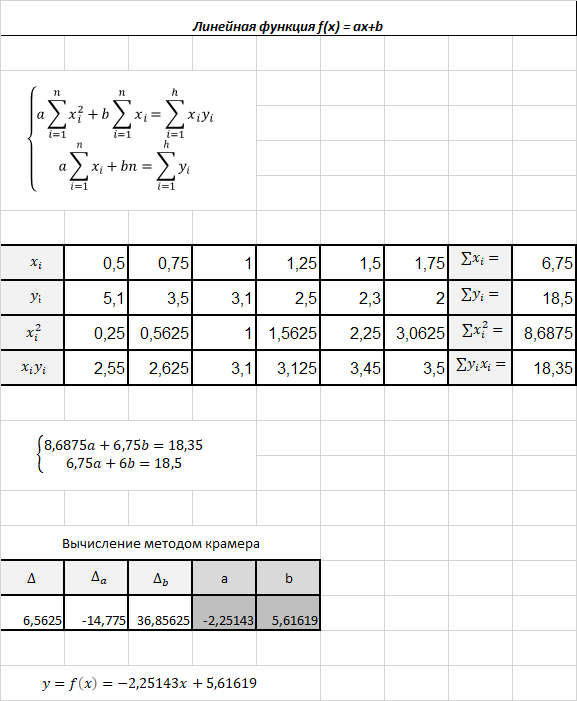

Построение графика

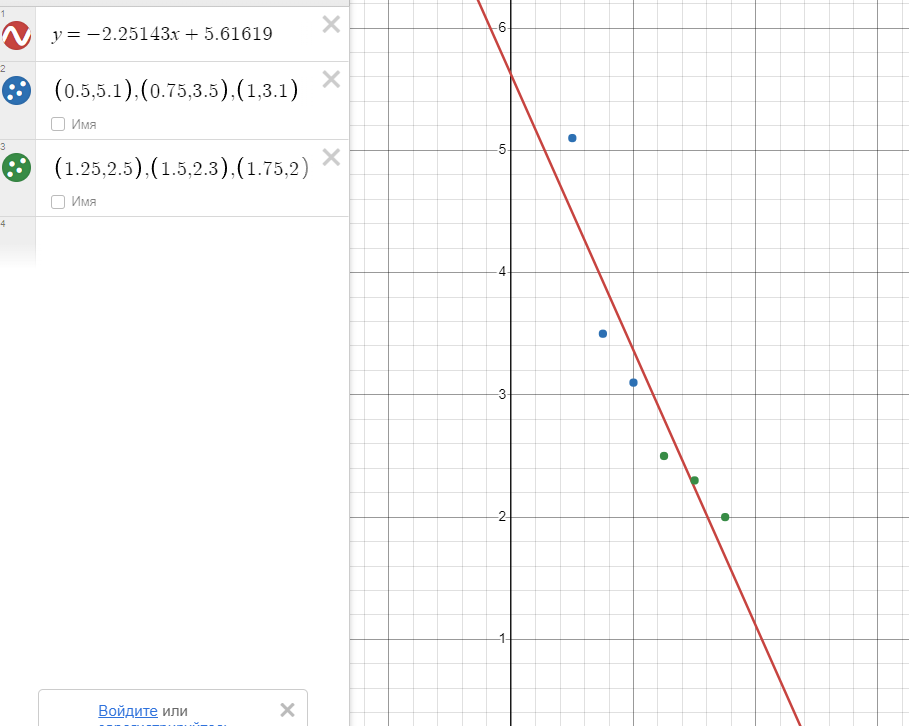

Вычисление суммы квадратов отклонений

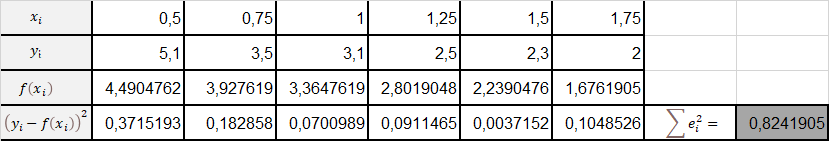

### **Параболическая функция**

**Расчёты системы:**
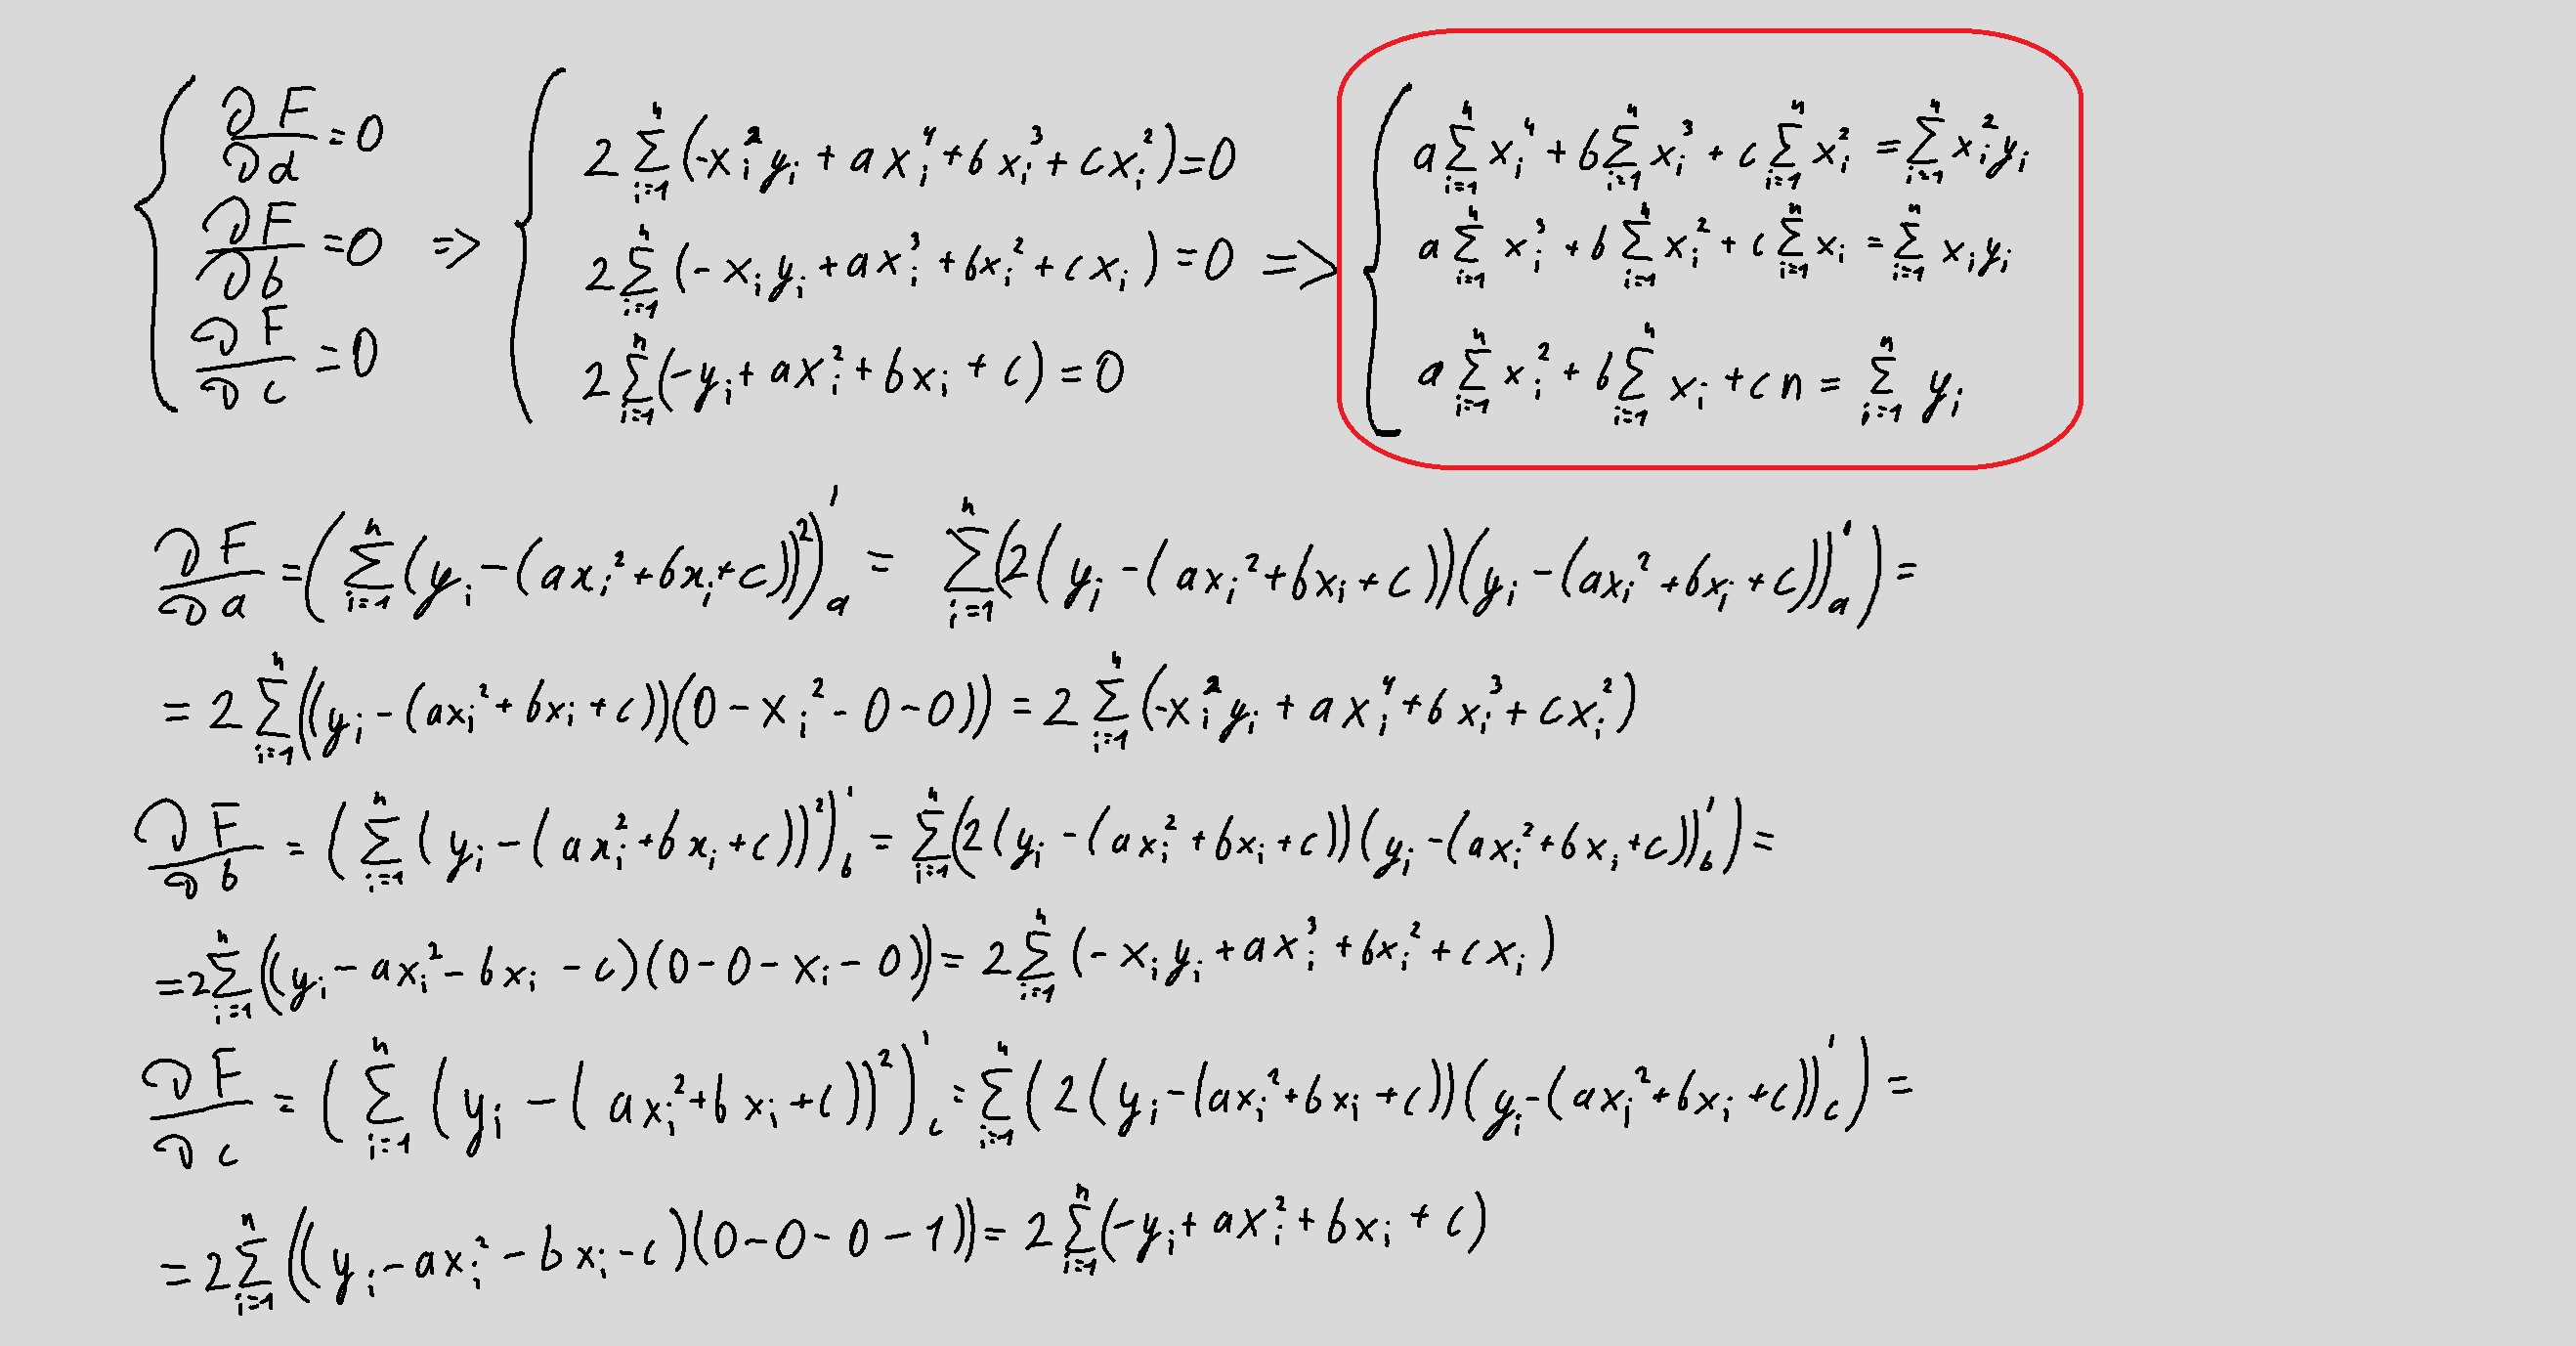

Расчёты

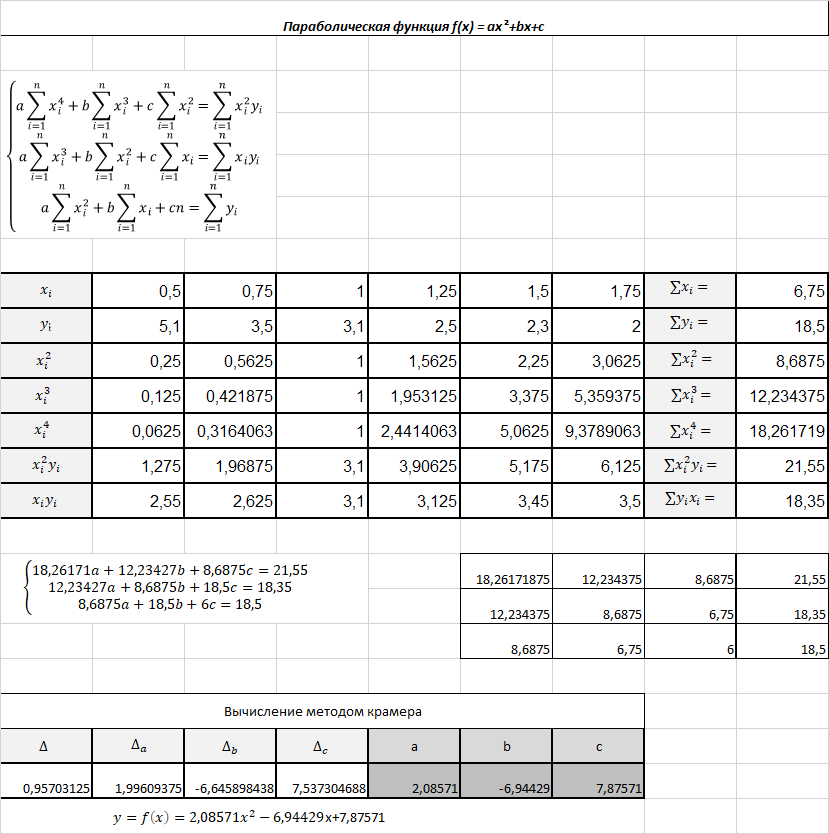

Построение графика

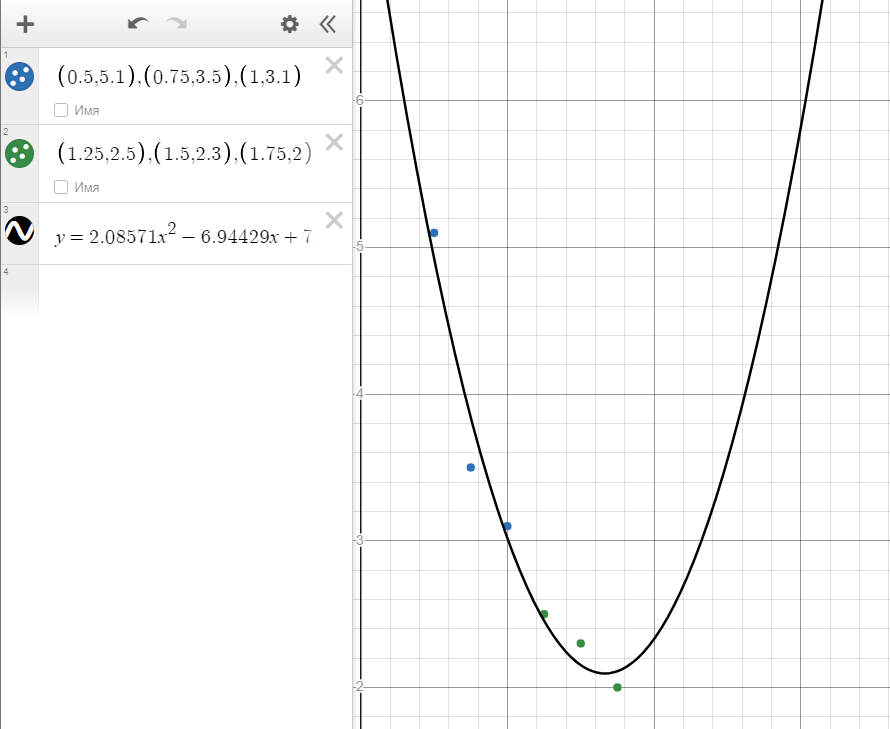

**Вычисление суммы квадратов отклонений**

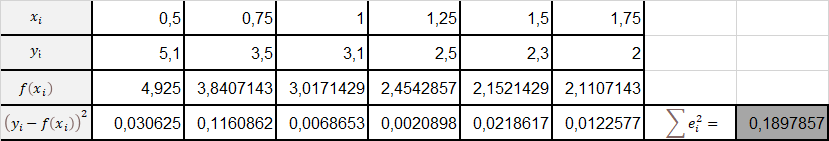

### **Гиперболическая функция**

**Расчёты системы:**
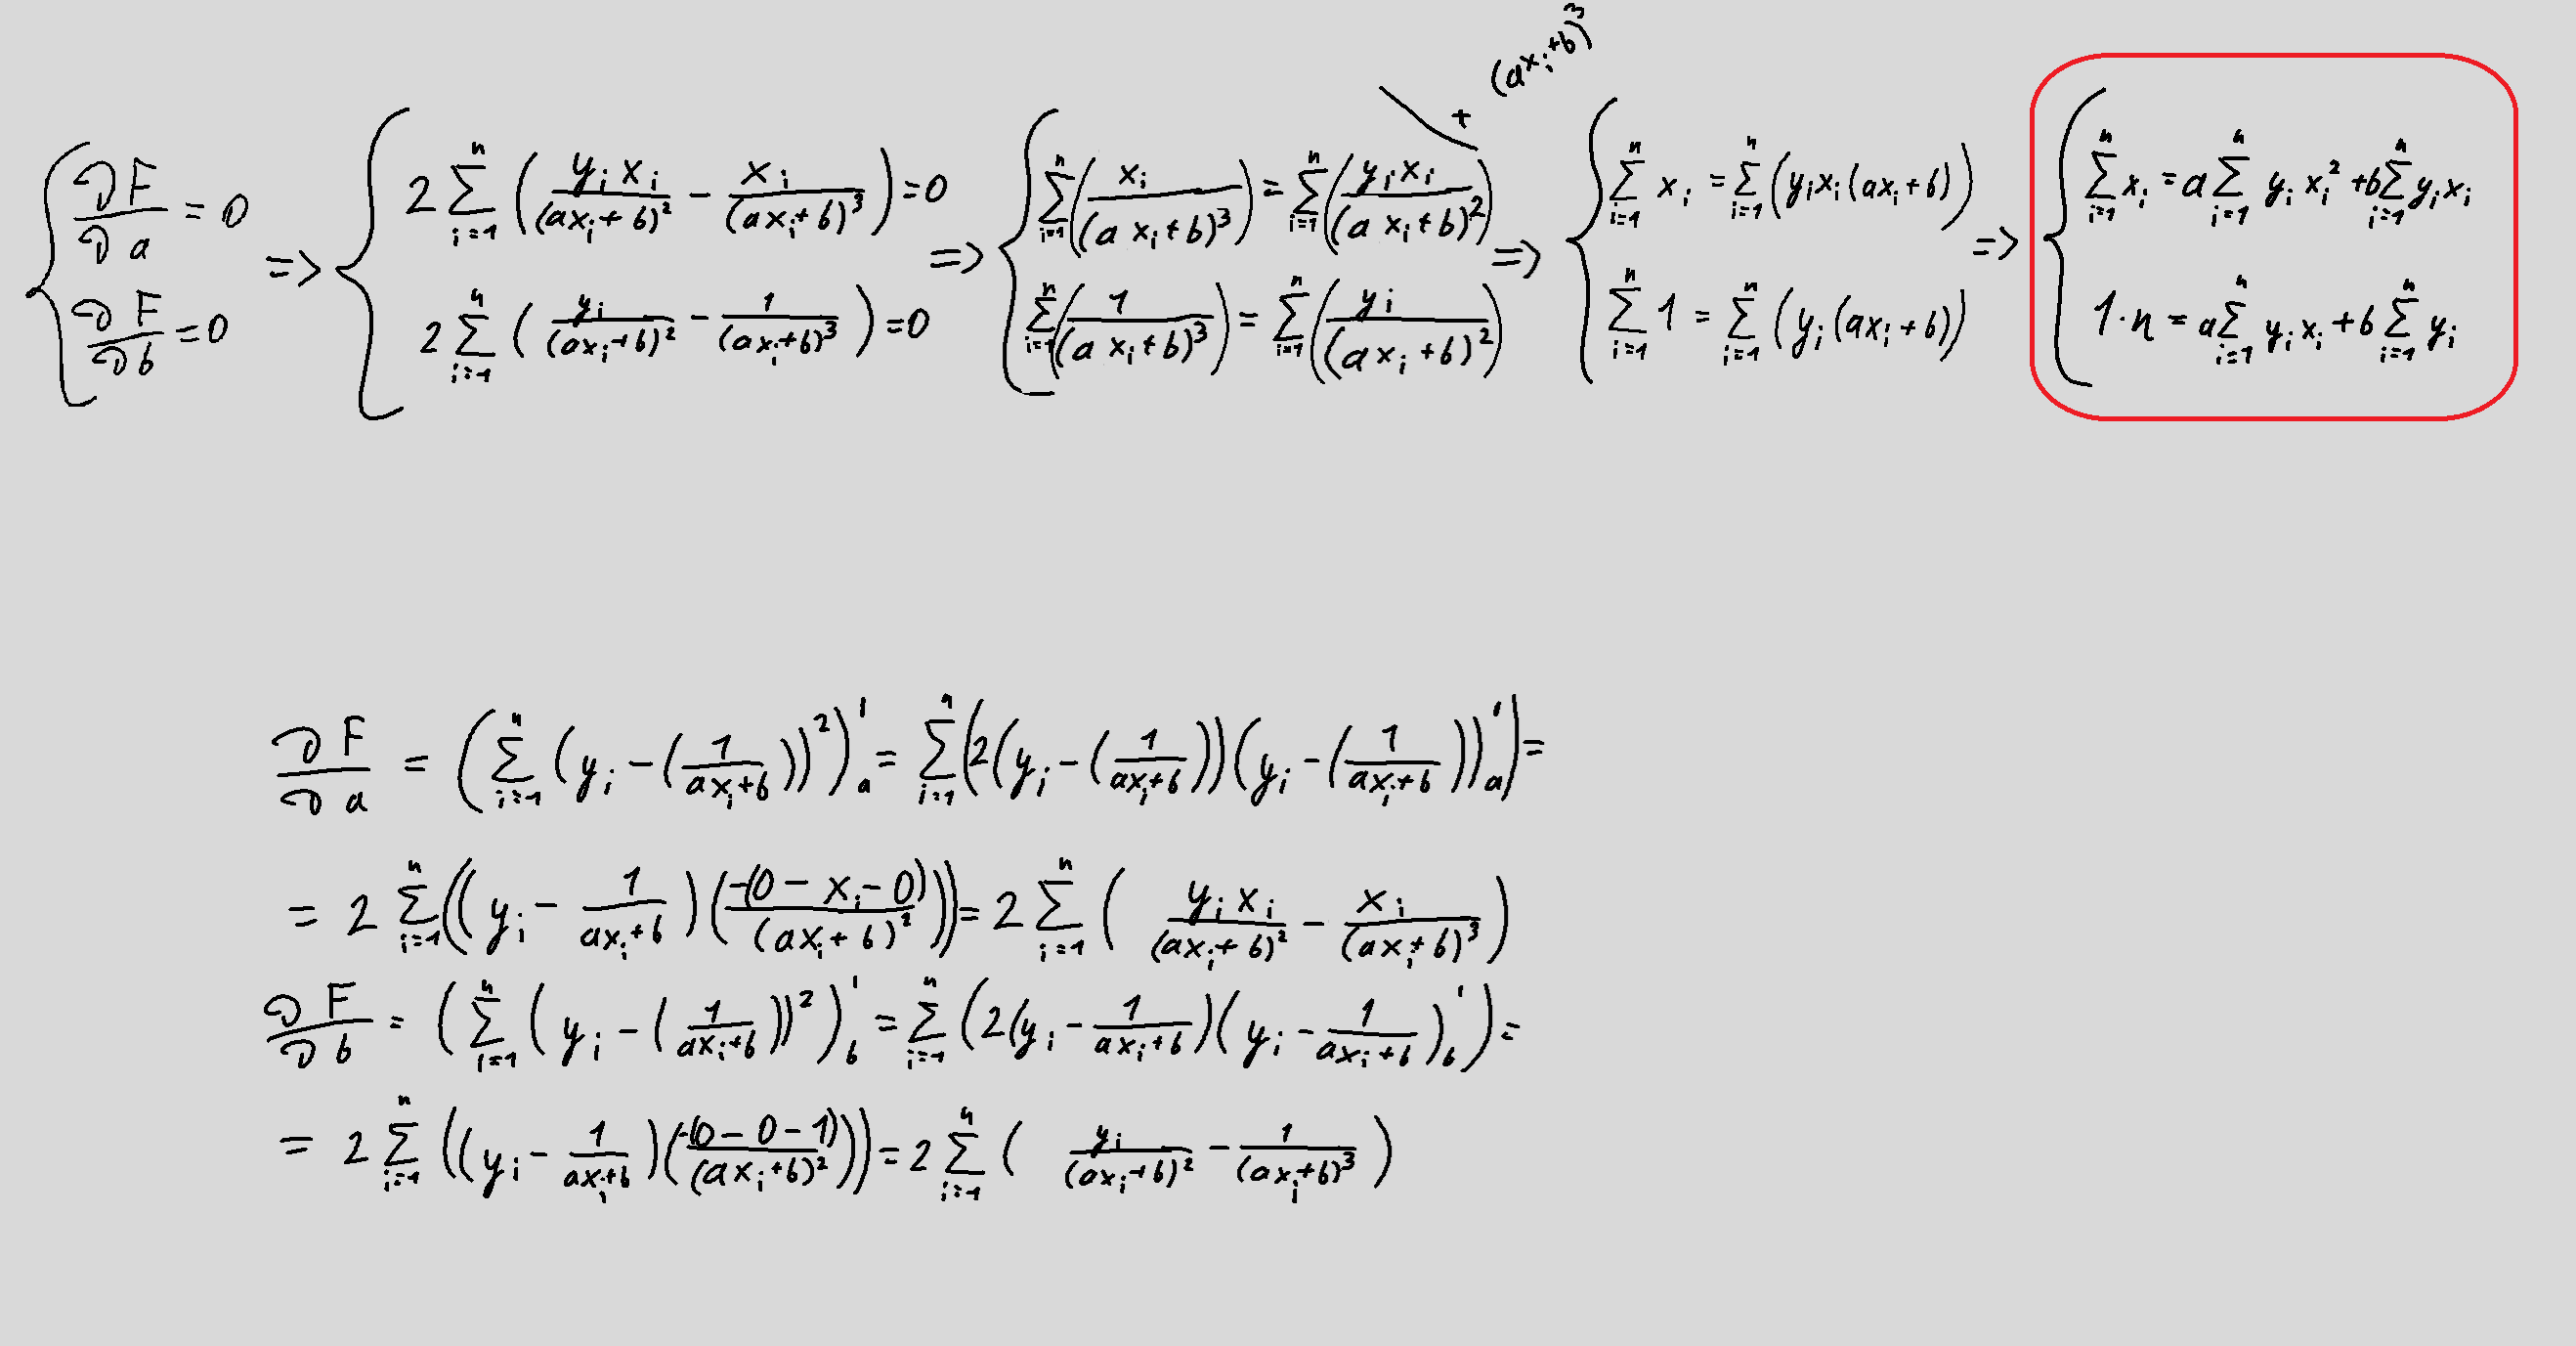

Расчёт:

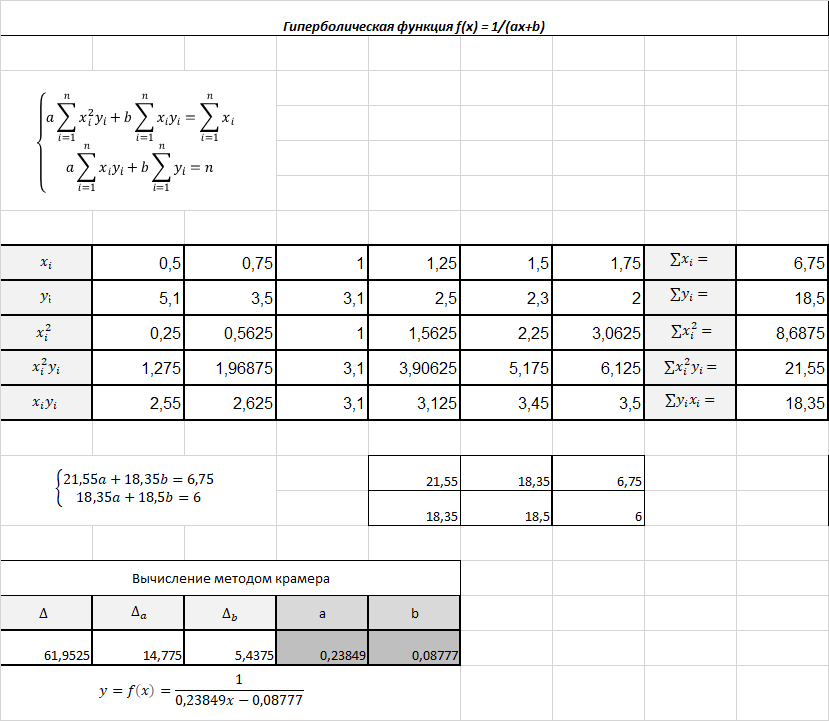

График:

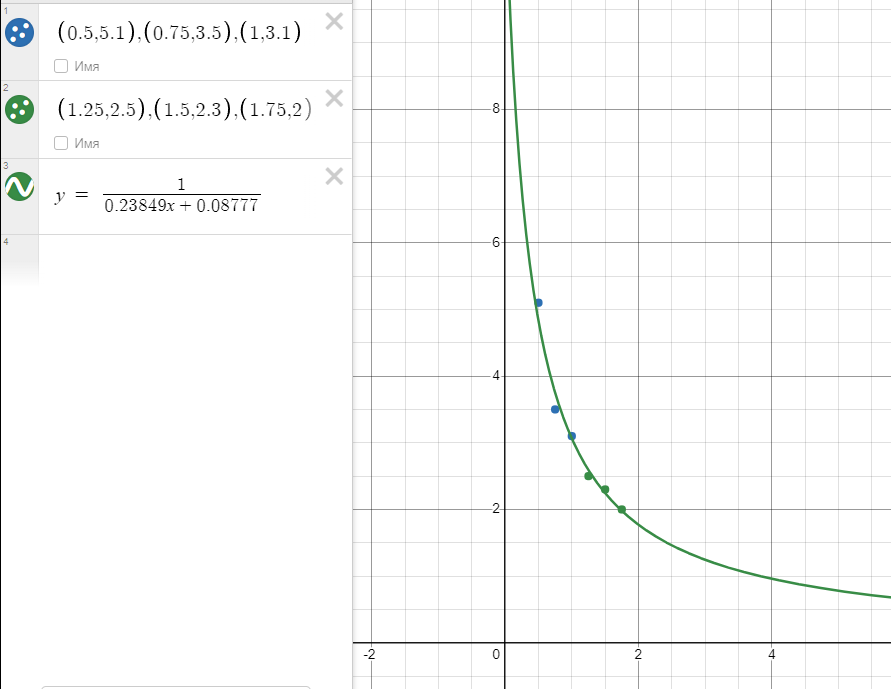

Вычисление суммы квадратов отклонений

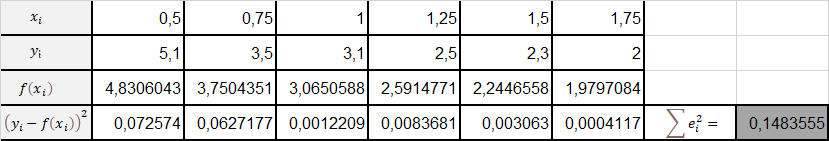

Итого получаем:

Линейная зависимость: 0.8241905

Параболическая зависимость: 0.1897857

Гиперболическая зависимость: 0.1483555

\
Наиболее точная зависимость - гиперболическая - с суммой квадратов отклонений в **0.1483555**

## Часть 2

Линейная функция

In [ ]:
def linearFunction(xValues, yValues):
  x2Values = xValues*xValues
  xyValues = xValues*yValues
  xSum = sum(xValues)
  ySum = sum(yValues)
  x2Sum = sum(x2Values)
  xySum = sum(xyValues)

  matrica = np.matrix([[x2Sum, xSum], [xSum, len(xValues)]])
  free_coef = np.array([[xySum],[ySum]])
  matrica_inv = np.linalg.inv(matrica)
  aValue, bValue = matrica_inv * free_coef

  sumSquares = 0
  for i in range(len(xValues)):
    sumSquares += (yValues[i] - aValue[0,0] * xValues[i] - bValue[0,0])**2

  return aValue, bValue, sumSquares

Параболическая функция

In [ ]:
def parabolFunction(xValues, yValues):
  x2Values = xValues*xValues
  x3Values = x2Values*xValues
  x4Values = x3Values*xValues
  xyValues = xValues*yValues
  x2yValues = x2Values*yValues
  xSum = sum(xValues)
  ySum = sum(yValues)
  x2Sum = sum(x2Values)
  x3Sum = sum(x3Values)
  x4Sum = sum(x4Values)
  xySum = sum(xyValues)
  x2ySum = sum(x2yValues)

  matrica = np.matrix([[x4Sum, x3Sum, x2Sum], [x3Sum, x2Sum, xSum], [x2Sum, xSum, len(xValues)]])
  free_coef = np.array([[x2ySum], [xySum], [ySum]])
  matrica_inv = np.linalg.inv(matrica)
  aValue, bValue, cValue = matrica_inv * free_coef

  sumSquares = 0
  for i in range(len(xValues)):
    sumSquares += (yValues[i] - aValue[0,0] * xValues[i]**2 - bValue[0,0] * xValues[i] - cValue[0,0])**2

  return aValue, bValue, cValue, sumSquares

Гиперболическая функция

In [ ]:
def giperbolFunction(xValues, yValues):
  x2Values = xValues*xValues
  xyValues = xValues*yValues
  x2yValues = x2Values*yValues
  xSum = sum(xValues)
  ySum = sum(yValues)
  x2Sum = sum(x2Values)
  xySum = sum(xyValues)
  x2ySum = sum(x2yValues)

  matrica = np.matrix([[x2ySum, xySum], [xySum, ySum]])
  free_coef = np.array([[xSum],[len(xValues)]])
  matrica_inv = np.linalg.inv(matrica)
  aValue, bValue = matrica_inv * free_coef

  sumSquares = 0
  for i in range(len(xValues)):
    sumSquares += (yValues[i] - 1 / (aValue[0,0] * xValues[i] + bValue[0,0]))**2

  return aValue, bValue, sumSquares

Работа с консолью

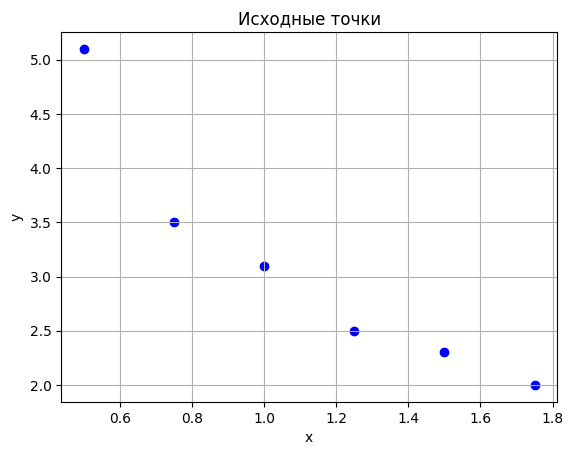

Линейная функция: -2.2514x + 5.6162
Сумма квадратов разностей: 0.8241904761904753



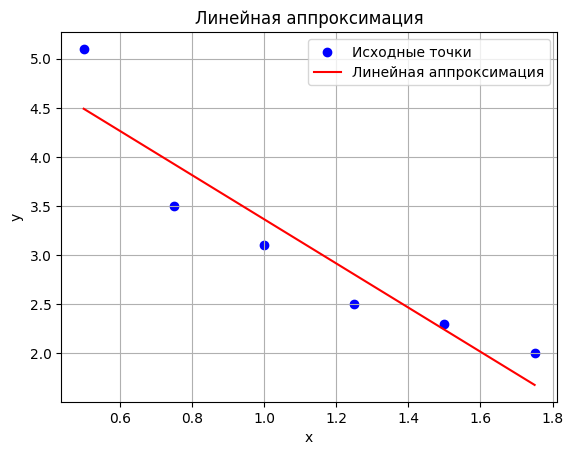

Параболическая функция: 2.0857x^2 + -6.9443x + 7.8757
Сумма квадратов разностей: 0.1897857142857137



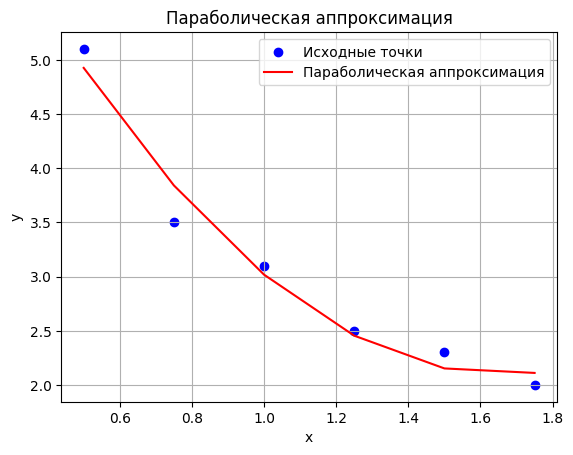

Гиперболическая функция: 1/(0.2385x + 0.0878)
Сумма квадратов разностей: 0.14835547914245956



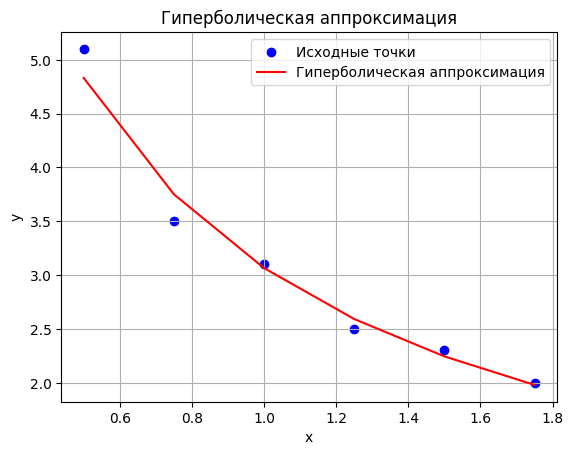

In [ ]:
xValues = np.array([0.50, 0.75, 1.00, 1.25, 1.50, 1.75])
yValues = np.array([5.1, 3.5, 3.1, 2.5, 2.3, 2.0])


# Точки на графике
plt.scatter(xValues, yValues, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Исходные точки')
plt.grid(True)
plt.show()


a, b, sumSquares = linearFunction(xValues, yValues)
print(f"Линейная функция: {a[0,0]:.4f}x + {b[0,0]:.4f}\nСумма квадратов разностей: {sumSquares}\n")


# Линейная аппроксимация
plt.scatter(xValues, yValues, color='blue', label='Исходные точки')
plt.plot(xValues, a[0,0] * xValues + b[0,0], color='red', label='Линейная аппроксимация')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Линейная аппроксимация')
plt.grid(True)
plt.show()


a, b, c, sumSquares = parabolFunction(xValues, yValues)
print(f"Параболическая функция: {a[0,0]:.4f}x^2 + {b[0,0]:.4f}x + {c[0,0]:.4f}\nСумма квадратов разностей: {sumSquares}\n")


# Параболическая аппроксимация
plt.scatter(xValues, yValues, color='blue', label='Исходные точки')
plt.plot(xValues, a[0,0] * xValues**2 + b[0,0] * xValues + c[0,0], color='red', label='Параболическая аппроксимация')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Параболическая аппроксимация')
plt.grid(True)
plt.show()


a, b, sumSquares = giperbolFunction(xValues, yValues)
print(f"Гиперболическая функция: 1/({a[0,0]:.4f}x + {b[0,0]:.4f})\nСумма квадратов разностей: {sumSquares}\n")


# Гиперболическая аппроксимация
plt.scatter(xValues, yValues, color='blue', label='Исходные точки')
plt.plot(xValues, 1 / (a[0,0] * xValues + b[0,0]), color='red', label='Гиперболическая аппроксимация')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Гиперболическая аппроксимация')
plt.grid(True)
plt.show()
